In this notebook we will describe three instruments for market analysis:
1. ARIMA model
2. Exponential smoothing
3. Fourier analysis

We will use the following libraries:
1. pandas
2. matplotlib
3. statsmodels

We will try to analyse different timeframes of BTC/USD price:
1. 1 hour
2. 1 day
3. 1 week

## Data loading and preprocessing

In [21]:
# Little help
import warnings
warnings.filterwarnings('ignore')

In [22]:
import pandas as pd
from typing import Dict

data: Dict[str, pd.DataFrame] = {
    "1h": pd.read_csv("C:/Users/Admin/PycharmProjects/GarbageCollector/data/BTCUSDT/BTCUSDT-1h.csv"),
    "1d": pd.read_csv("C:/Users/Admin/PycharmProjects/GarbageCollector/data/BTCUSDT/BTCUSDT-1d.csv"),
    "1w": pd.read_csv("C:/Users/Admin/PycharmProjects/GarbageCollector/data/BTCUSDT/BTCUSDT-1w.csv")
}

for key, value in data.items():
    print(f"{key}: {value.shape}")

1h: (54963, 8)
1d: (2296, 8)
1w: (329, 8)


In [23]:
# Unix time to datetime
for key, value in data.items():
    data[key]["open_time"] = pd.to_datetime(data[key]["open_time"], unit="ms")

In [24]:
# Set index
for key, value in data.items():
    data[key].set_index("open_time", inplace=True)

## ARIMA model

In [25]:
# Data preparation for ARIMA model (need only close price)
data_arima = {key: value["close"] for key, value in data.items()}

for key, value in data_arima.items():
    print(f"{key}: {value.shape}")

1h: (54963,)
1d: (2296,)
1w: (329,)


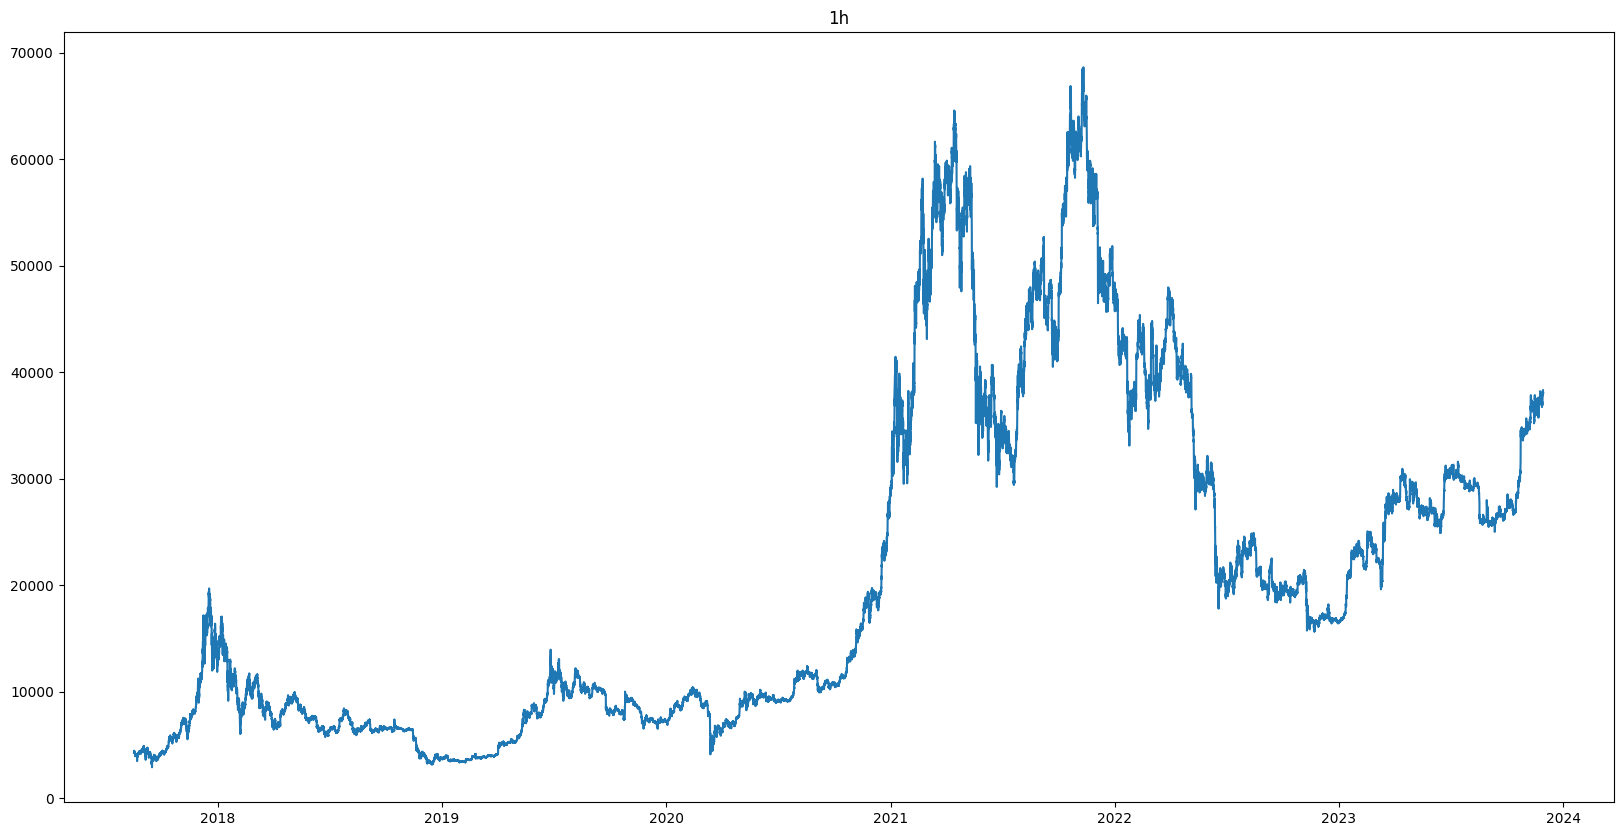

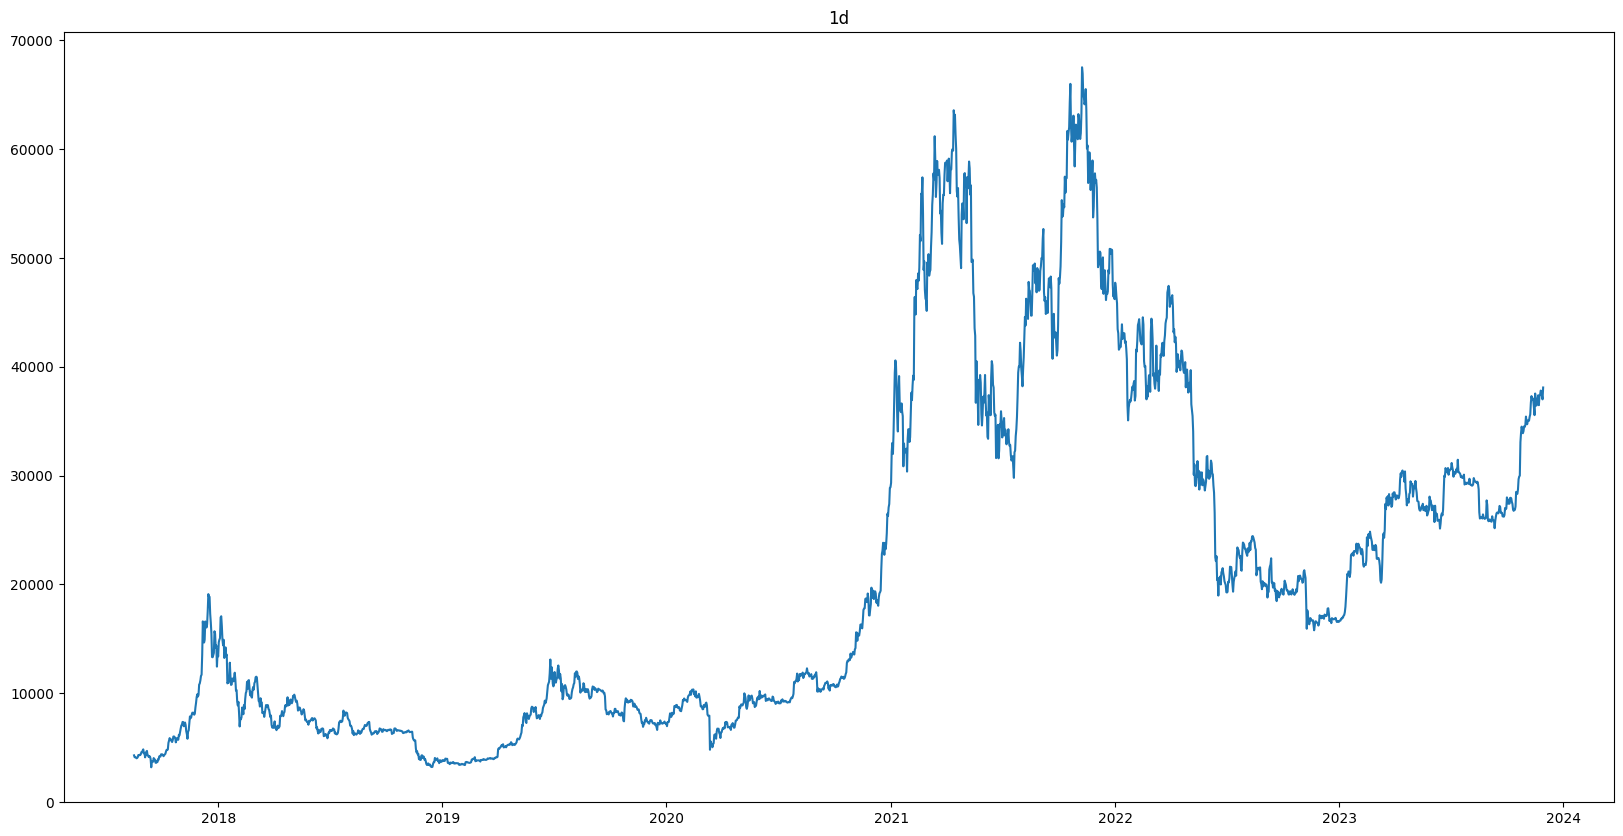

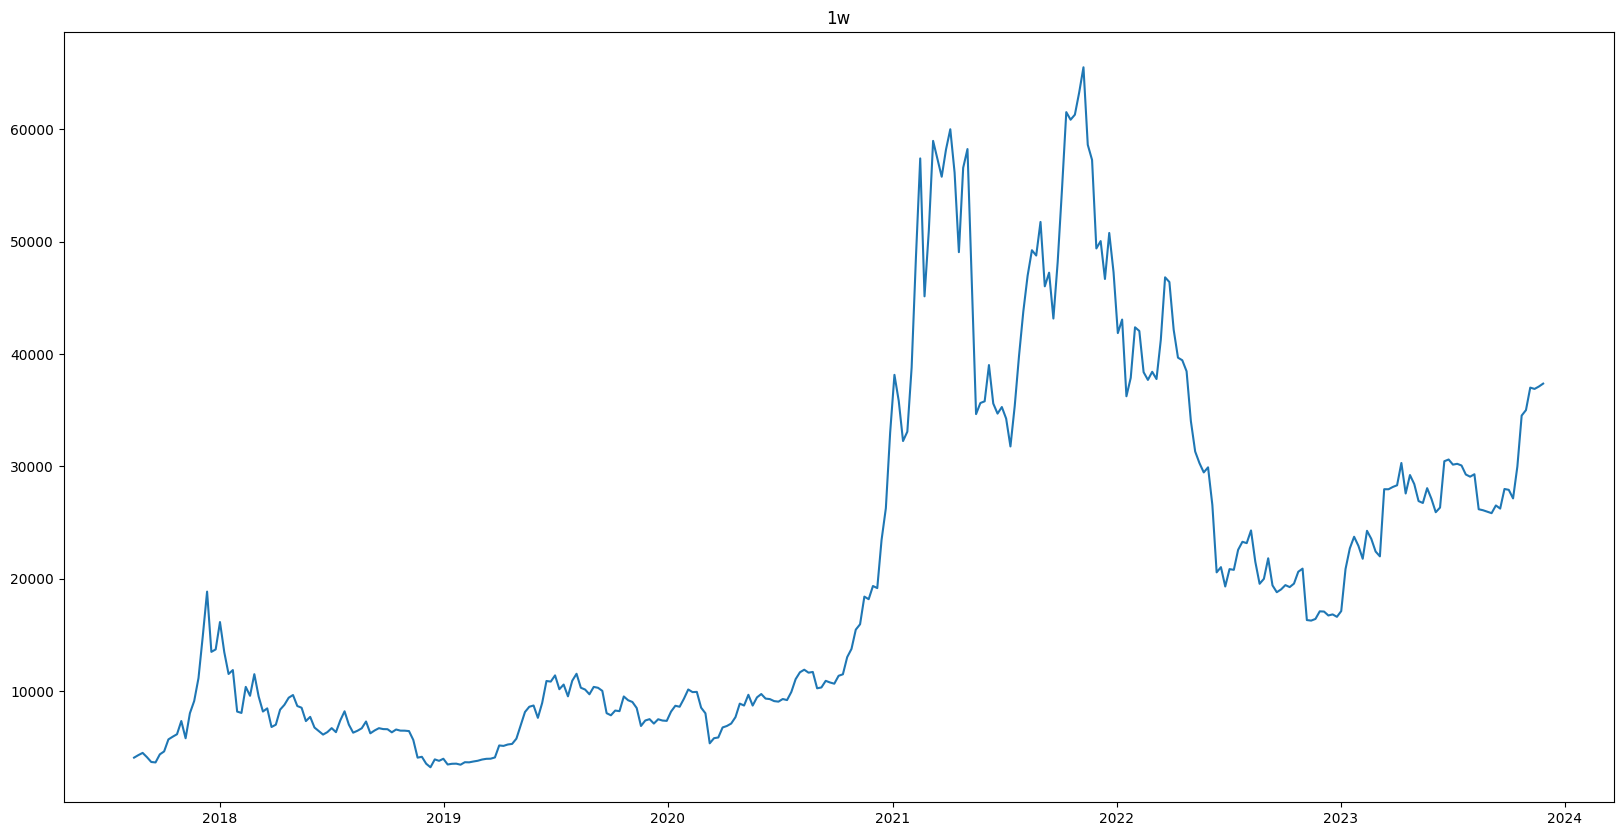

In [26]:
# Plot data
import matplotlib.pyplot as plt

for key, value in data_arima.items():
    plt.figure(figsize=(20, 10))
    plt.plot(value)
    plt.title(key)
    plt.show()

Now we need to describe parameters

First is d - order of differentiation

At all 0, 1 or 2, but we need to choose the best one. Most common way is to plot autocorrelation and partial autocorrelation and choose the best one. Also we will use 0, 1 and 2 order differencing and compare results.

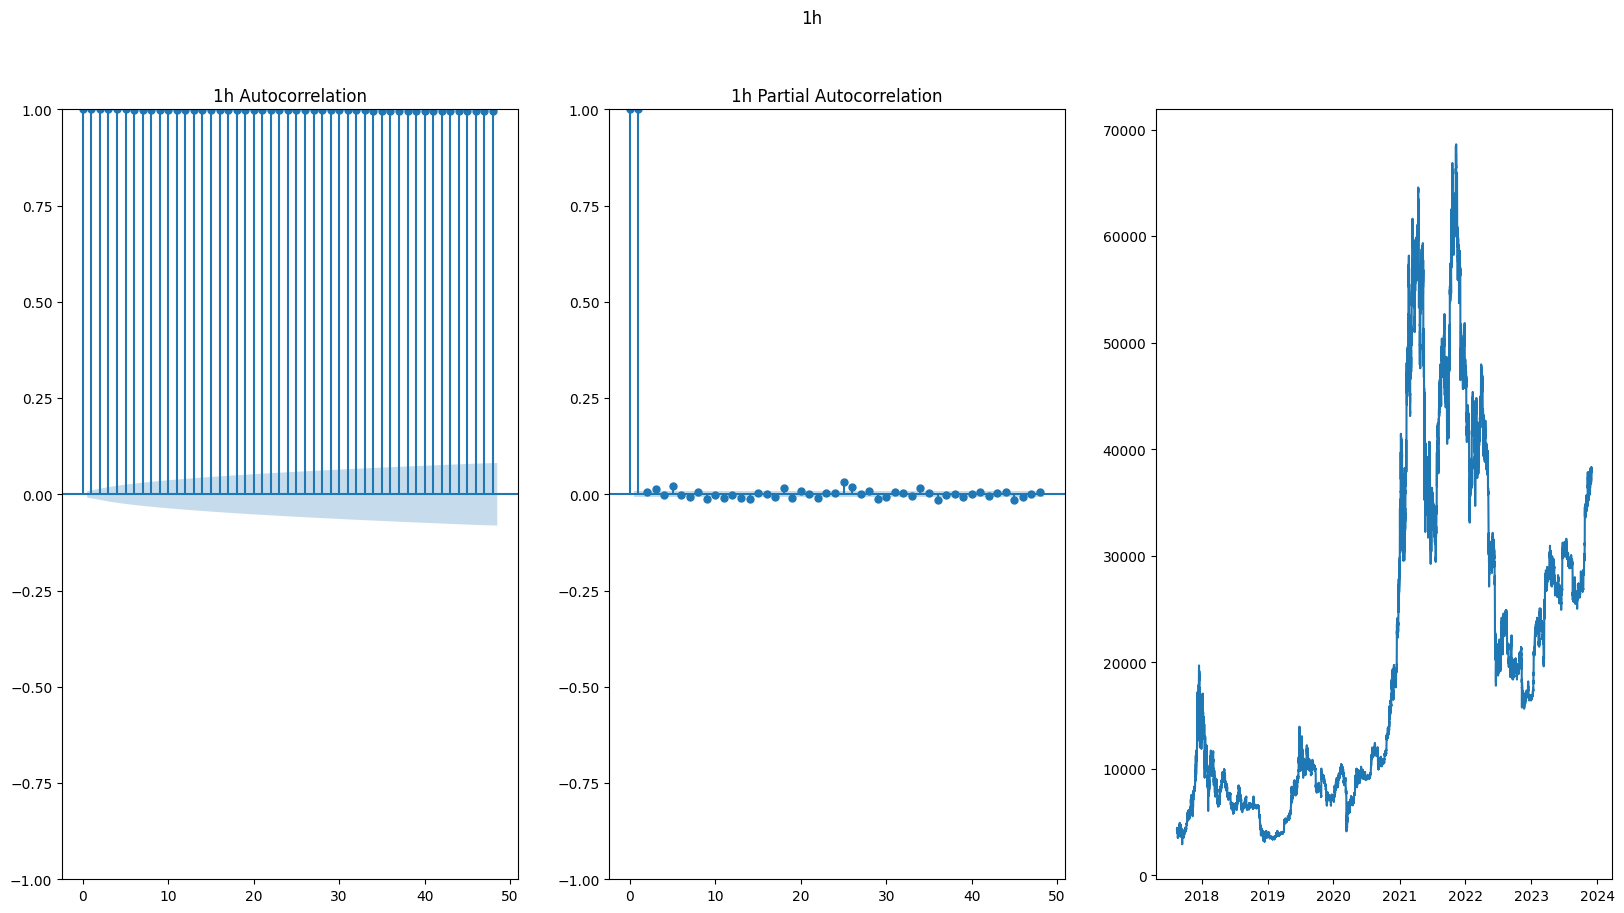

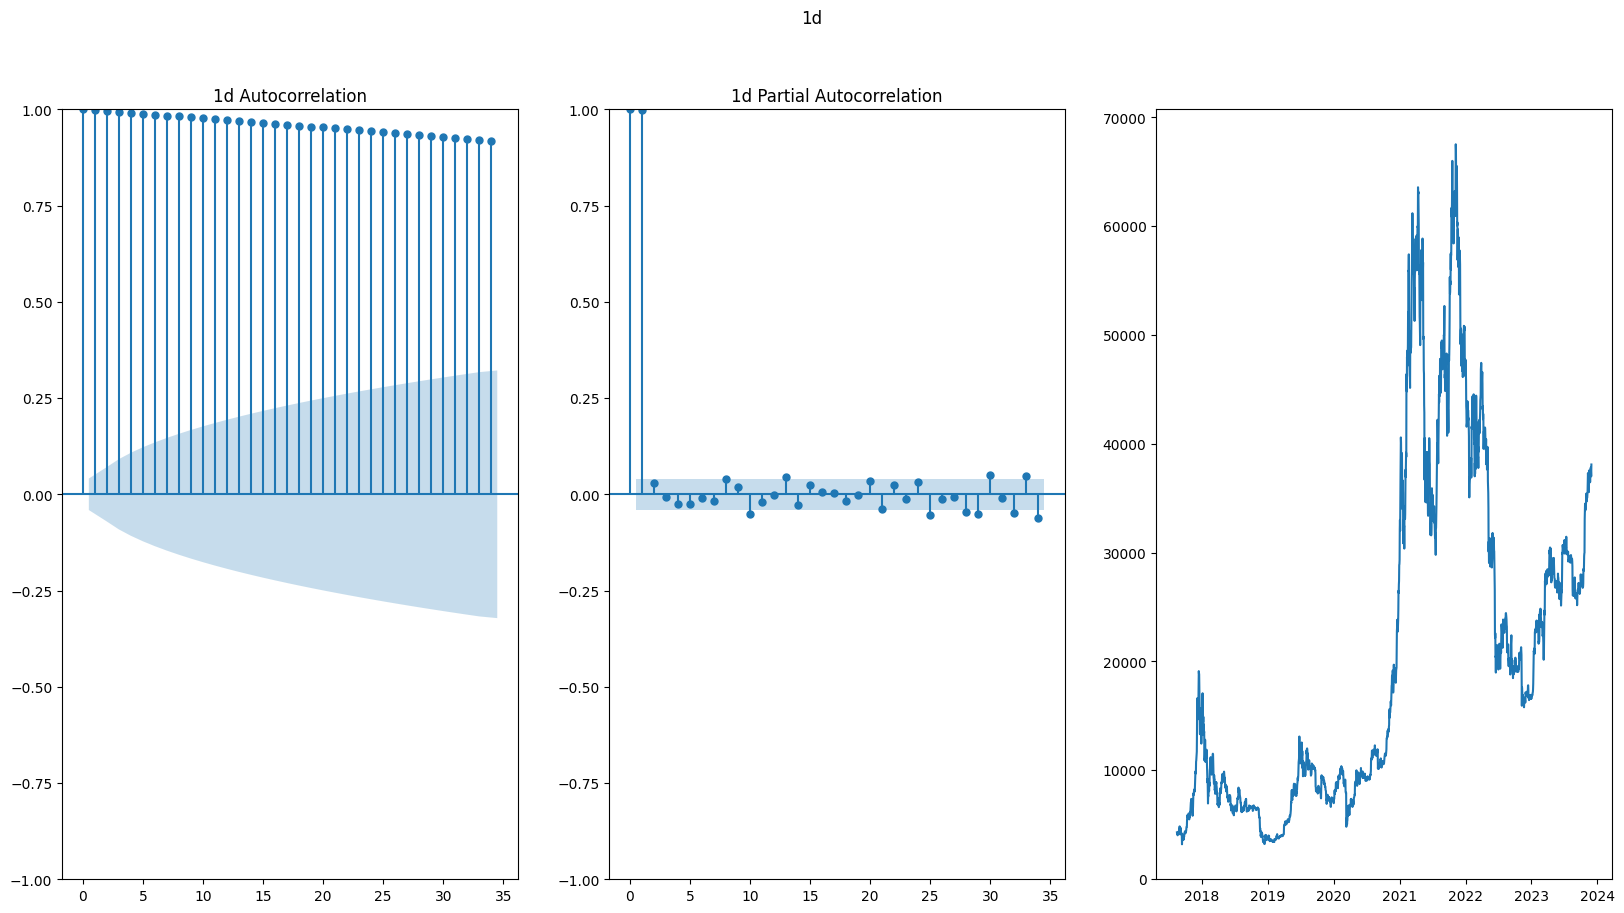

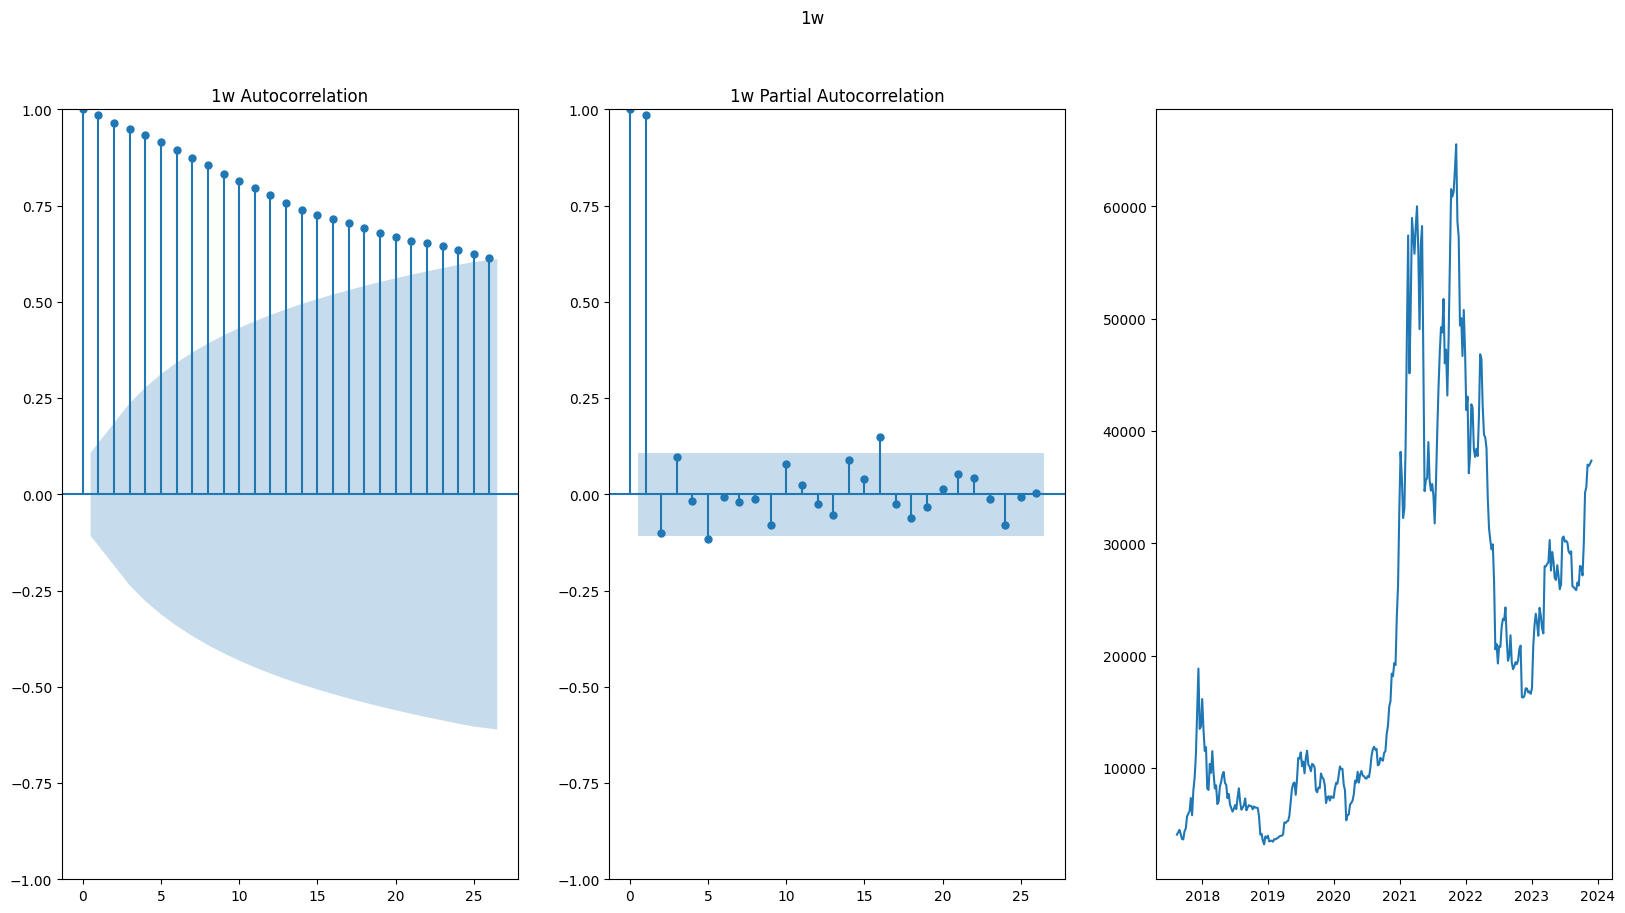

In [27]:
# 0 order differencing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for key, value in data_arima.items():
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    plot_acf(value, ax=axes[0], title=f"{key} Autocorrelation")
    plot_pacf(value, ax=axes[1], title=f"{key} Partial Autocorrelation")
    axes[2].plot(value, label=f"{key} Original")
    fig.suptitle(key)
    plt.show()

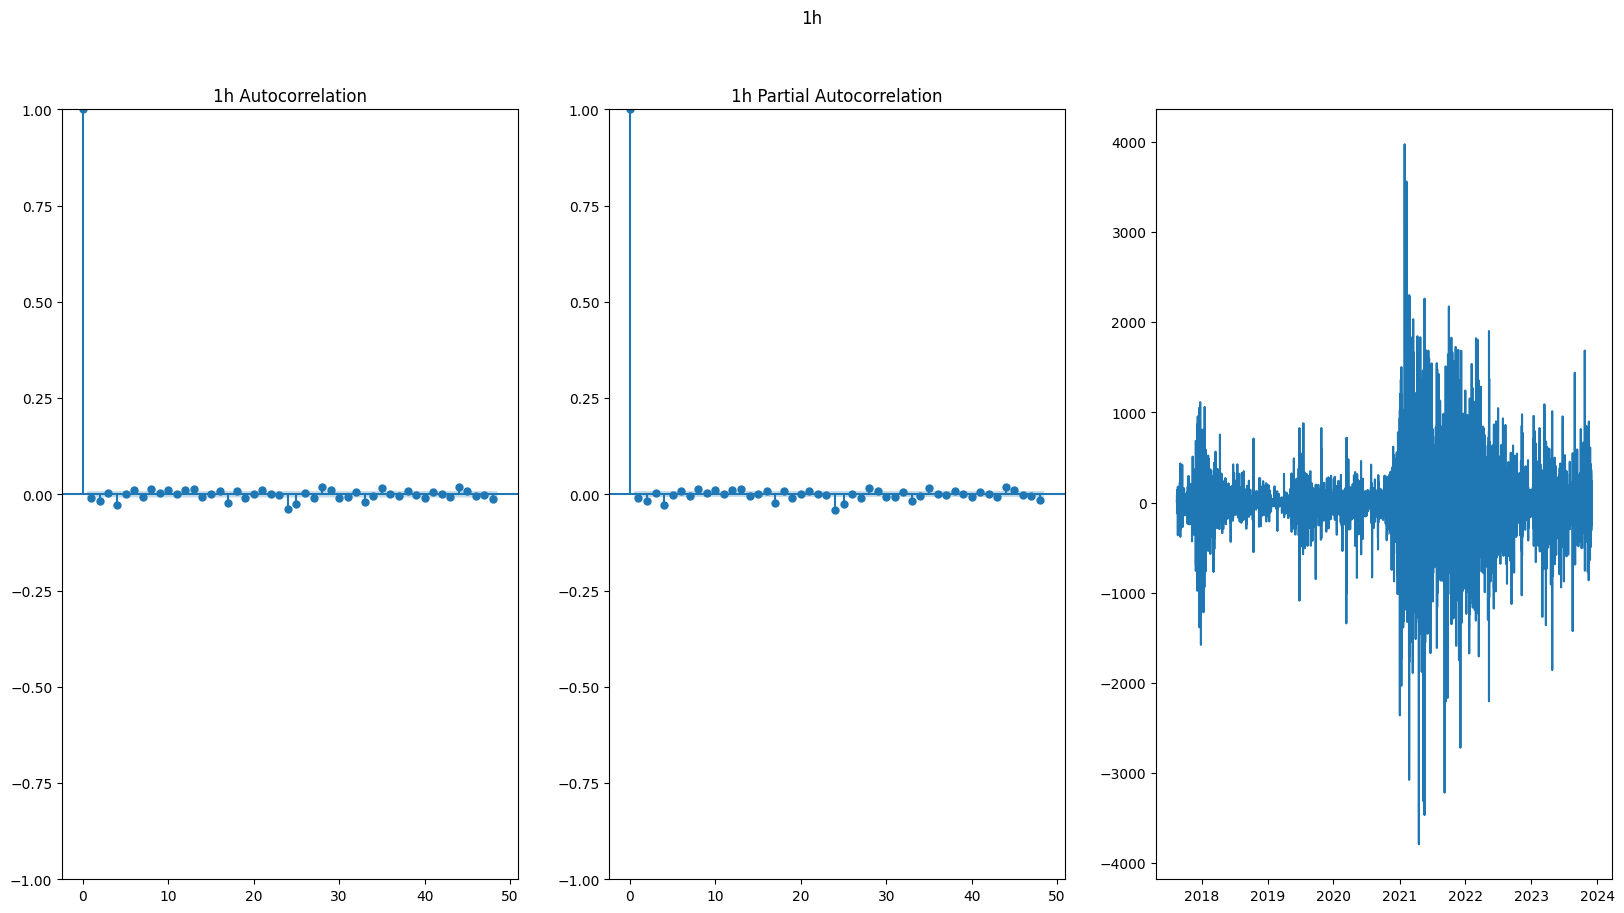

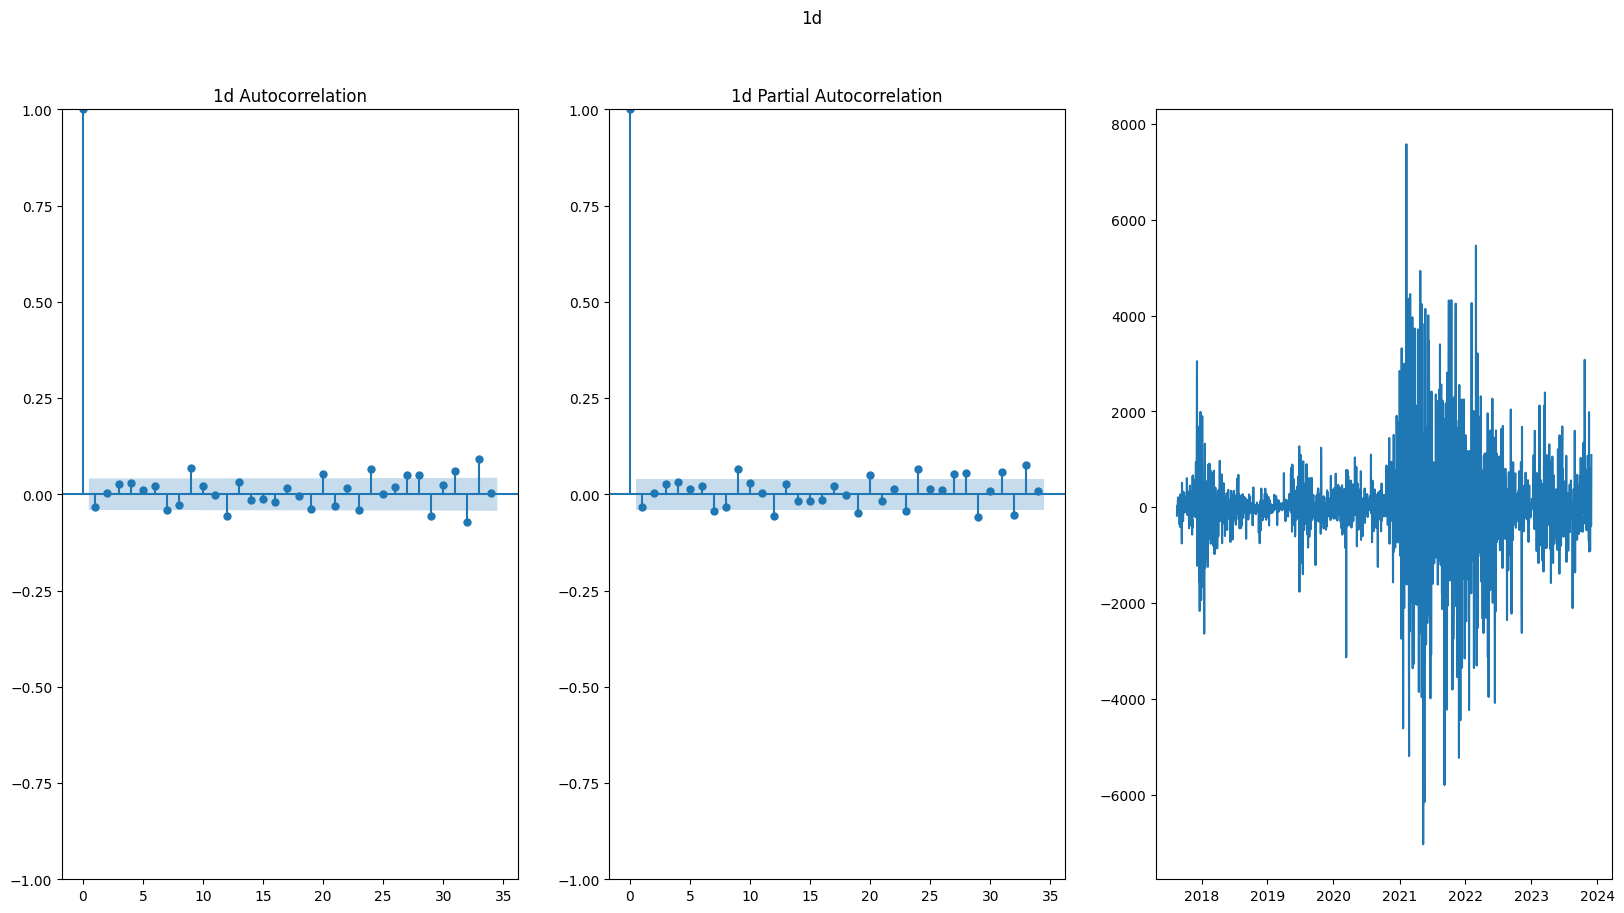

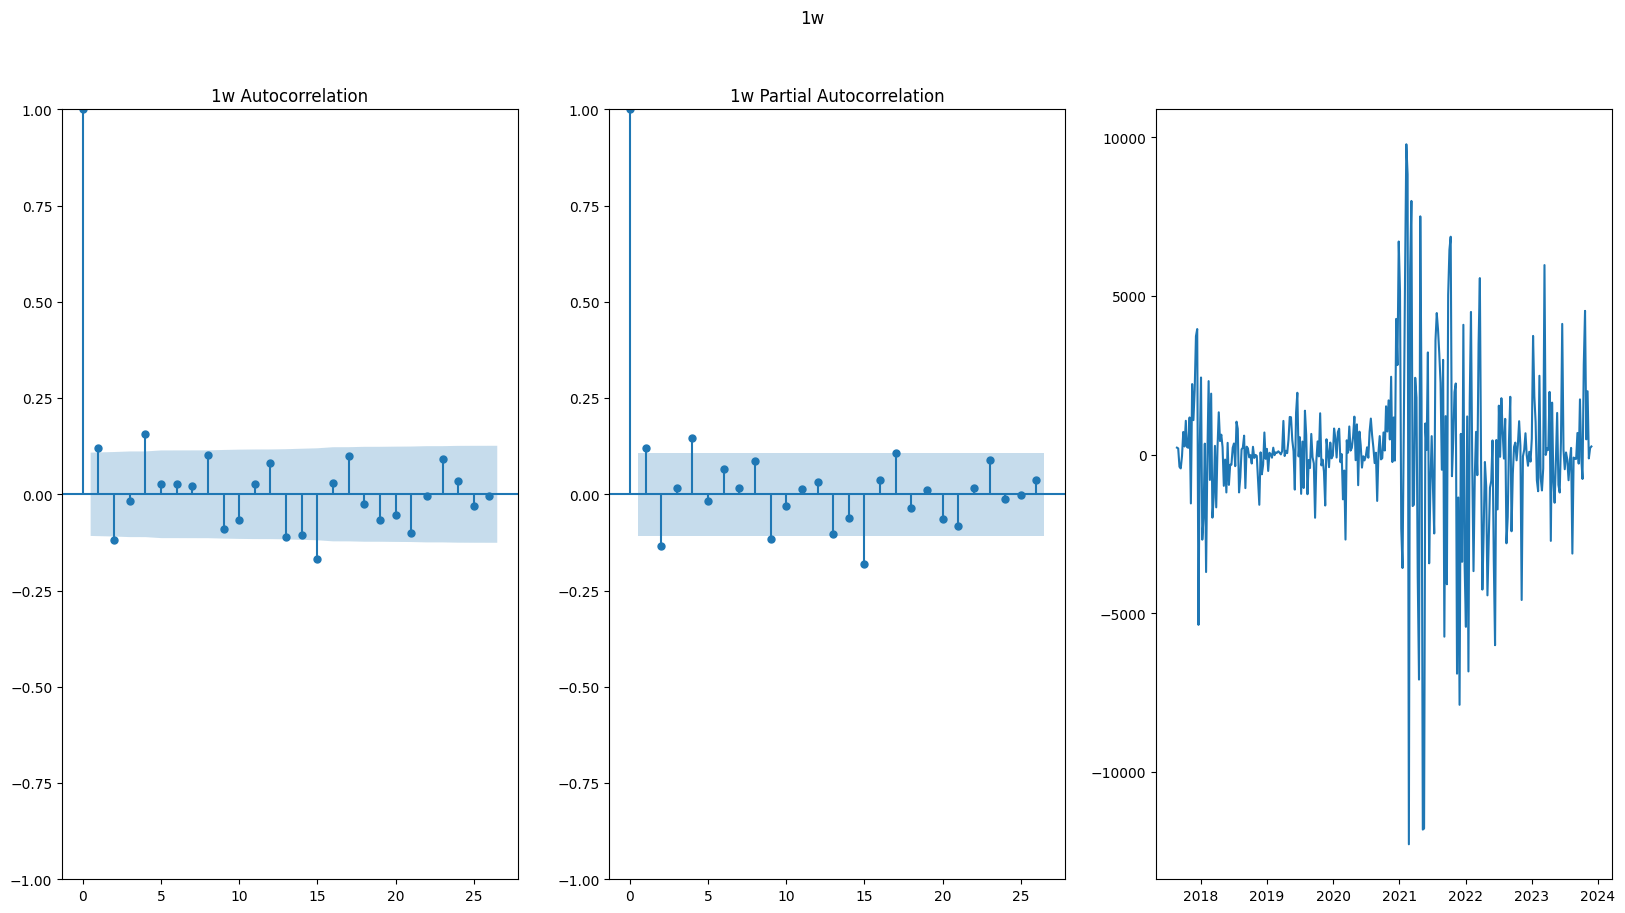

In [28]:
# 1 order differencing
for key, value in data_arima.items():
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    val = value.diff().dropna()
    plot_acf(val, ax=axes[0], title=f"{key} Autocorrelation")
    plot_pacf(val, ax=axes[1], title=f"{key} Partial Autocorrelation")
    axes[2].plot(val, label=f"{key} Original")
    fig.suptitle(key)
    plt.show()

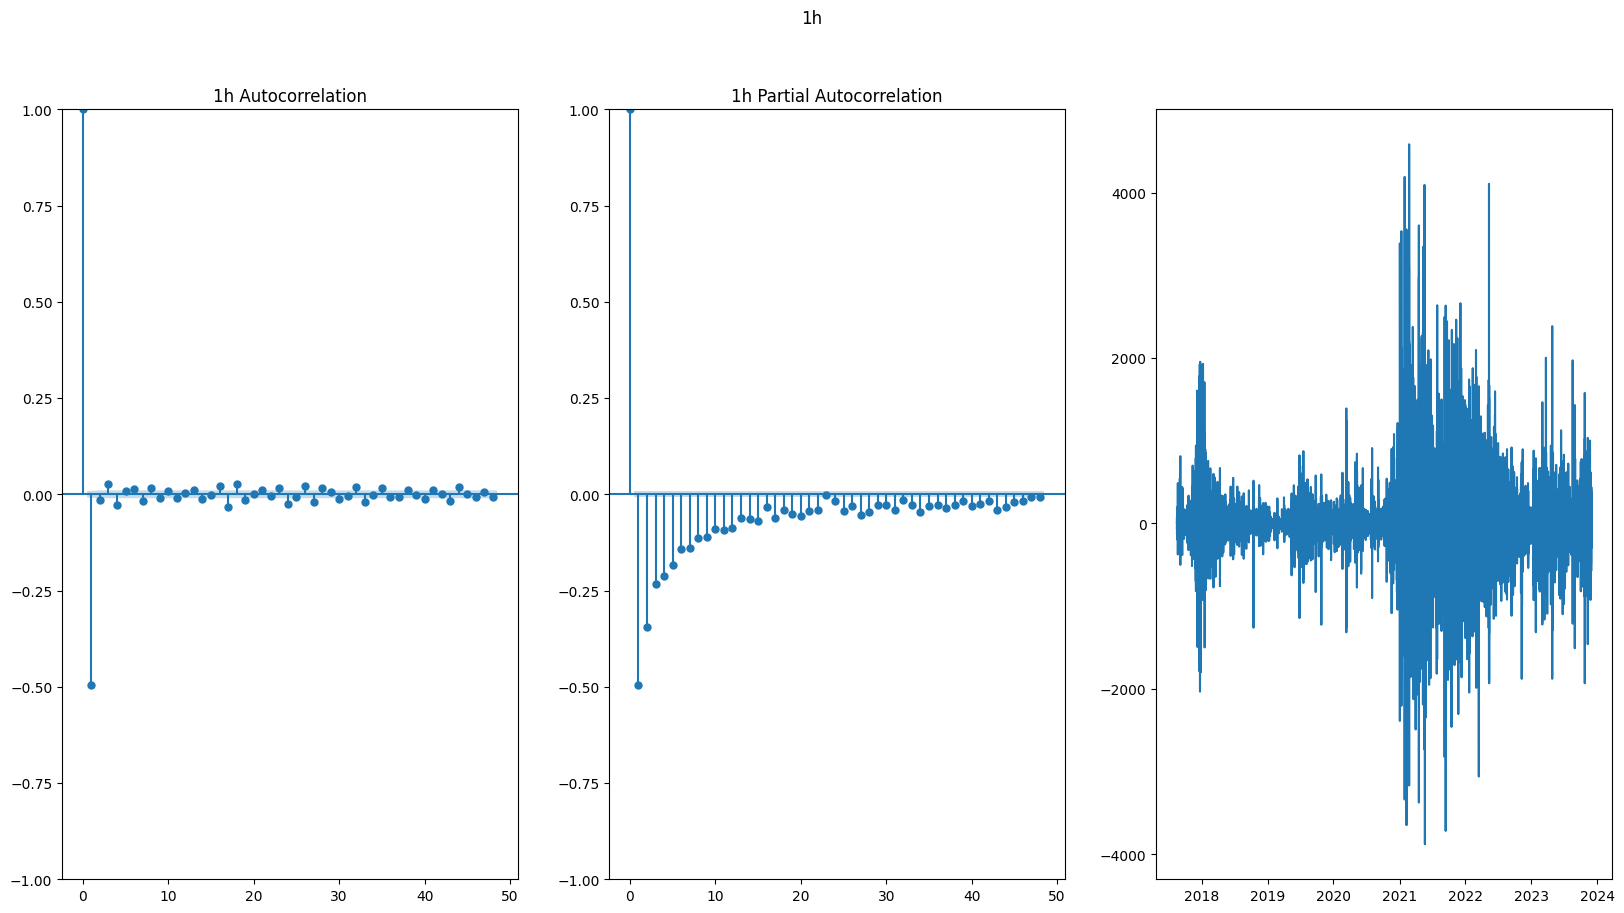

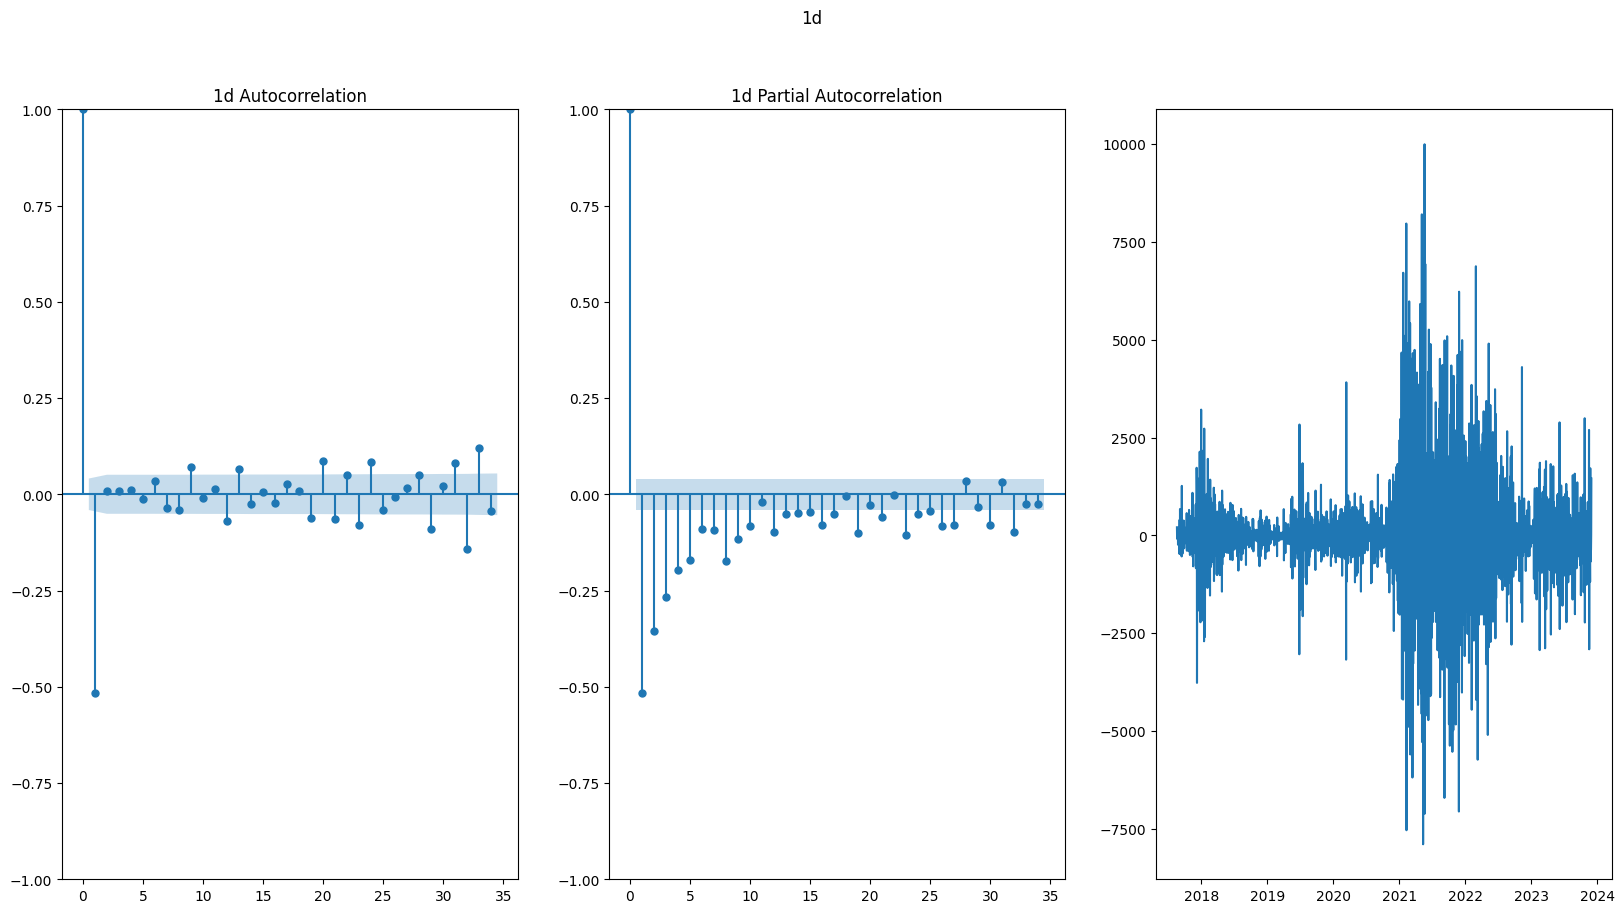

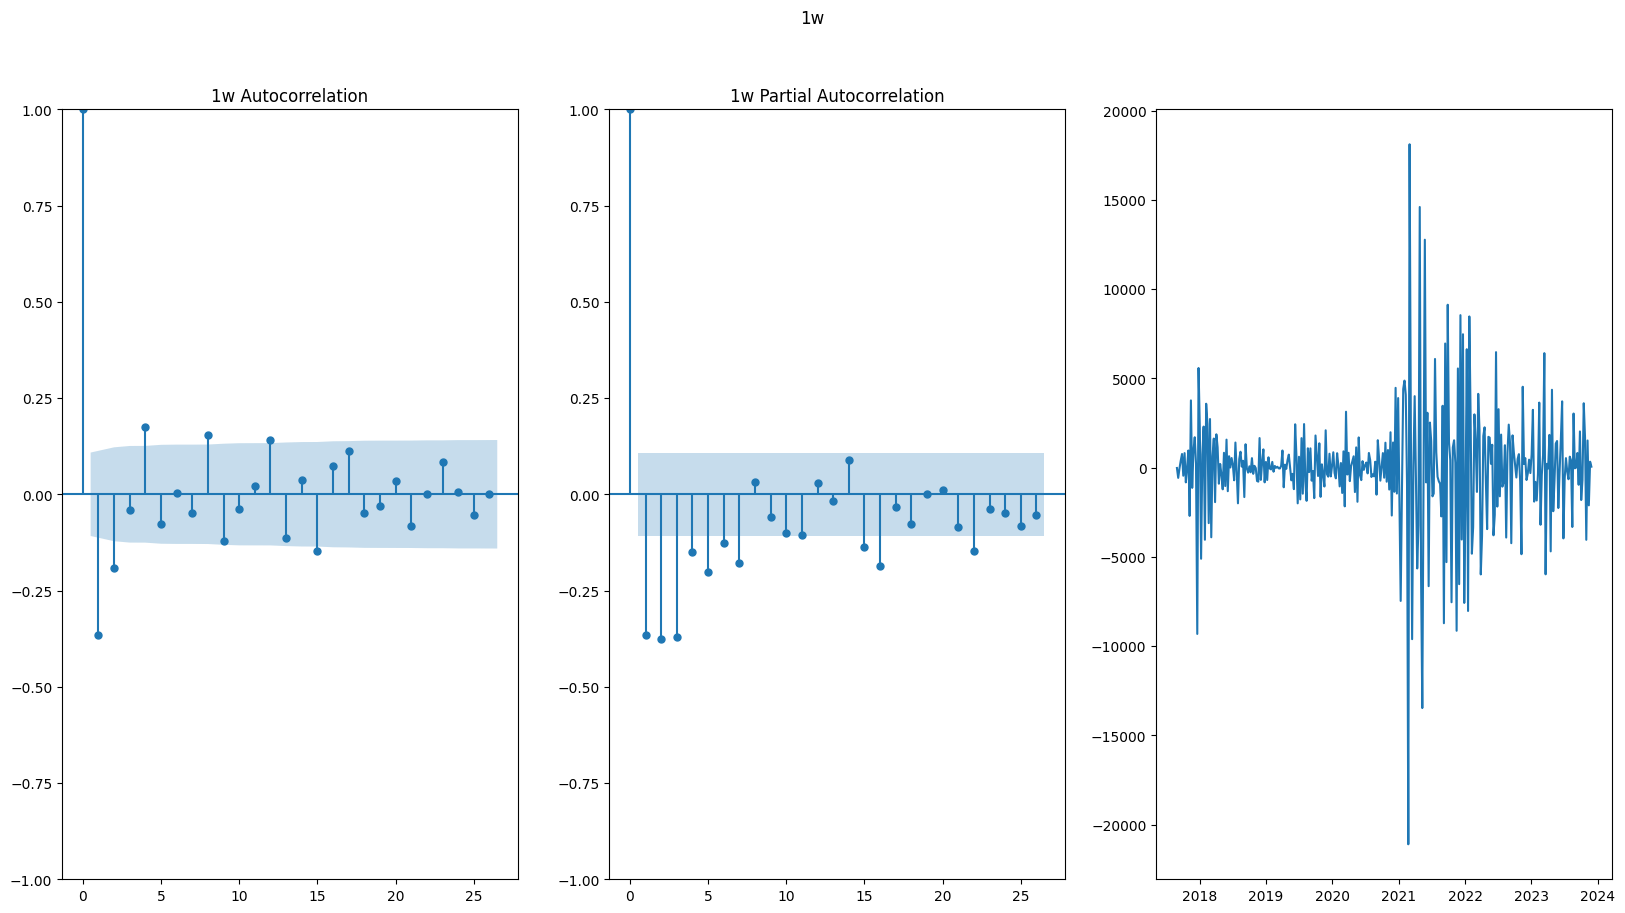

In [29]:
# 2 order differencing
for key, value in data_arima.items():
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    val = value.diff().diff().dropna()
    plot_acf(val, ax=axes[0], title=f"{key} Autocorrelation")
    plot_pacf(val, ax=axes[1], title=f"{key} Partial Autocorrelation")
    axes[2].plot(val, label=f"{key} Original")
    fig.suptitle(key)
    plt.show()

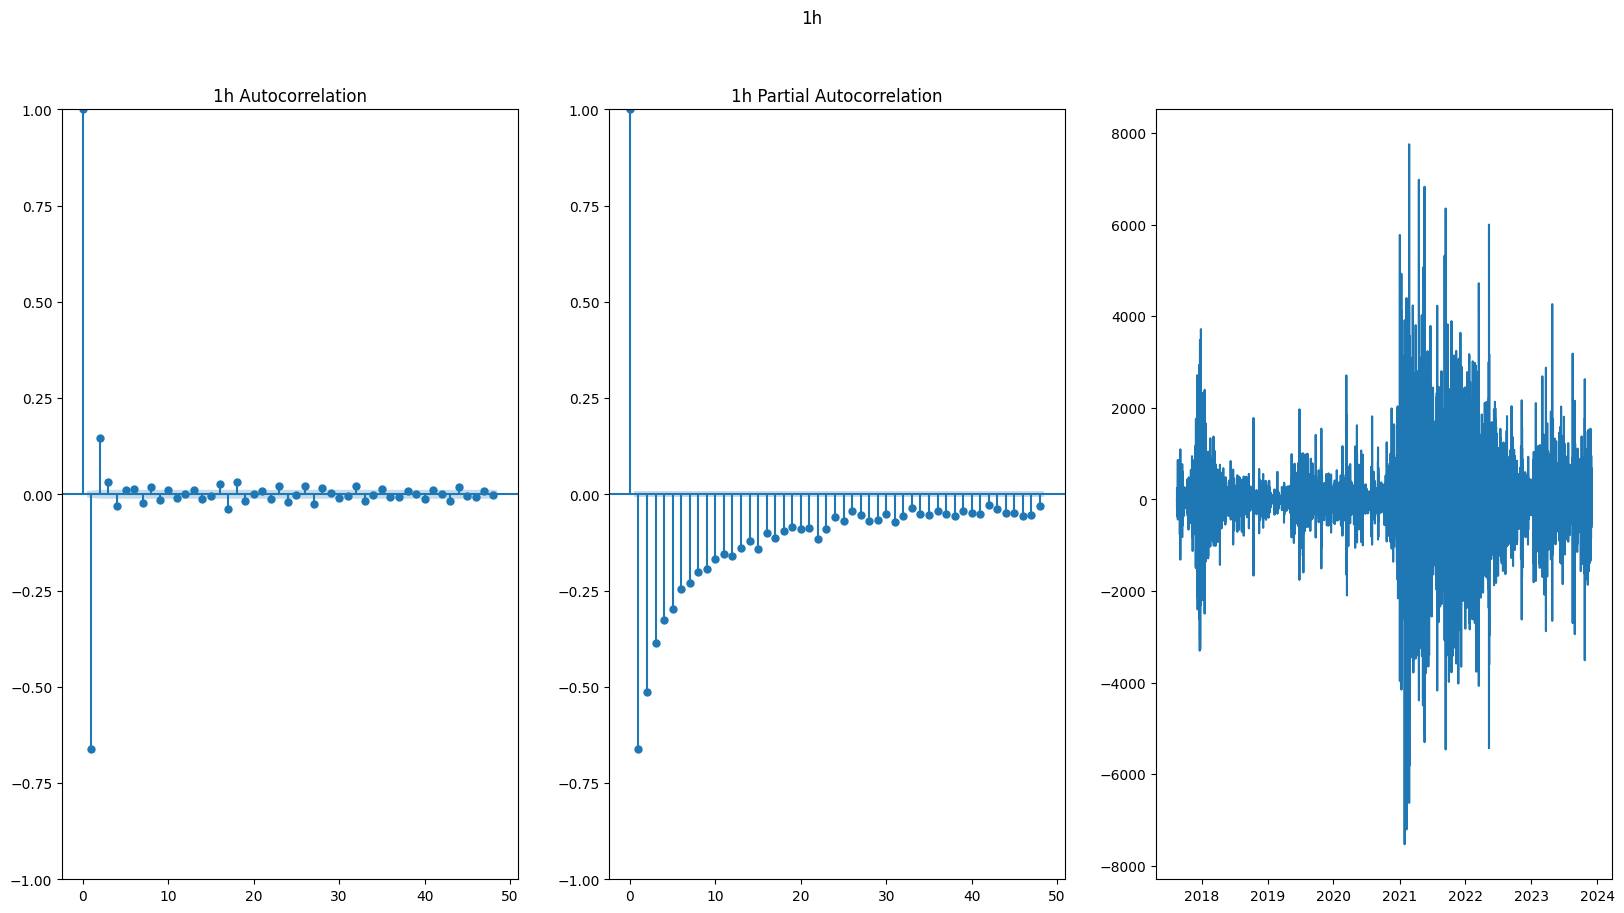

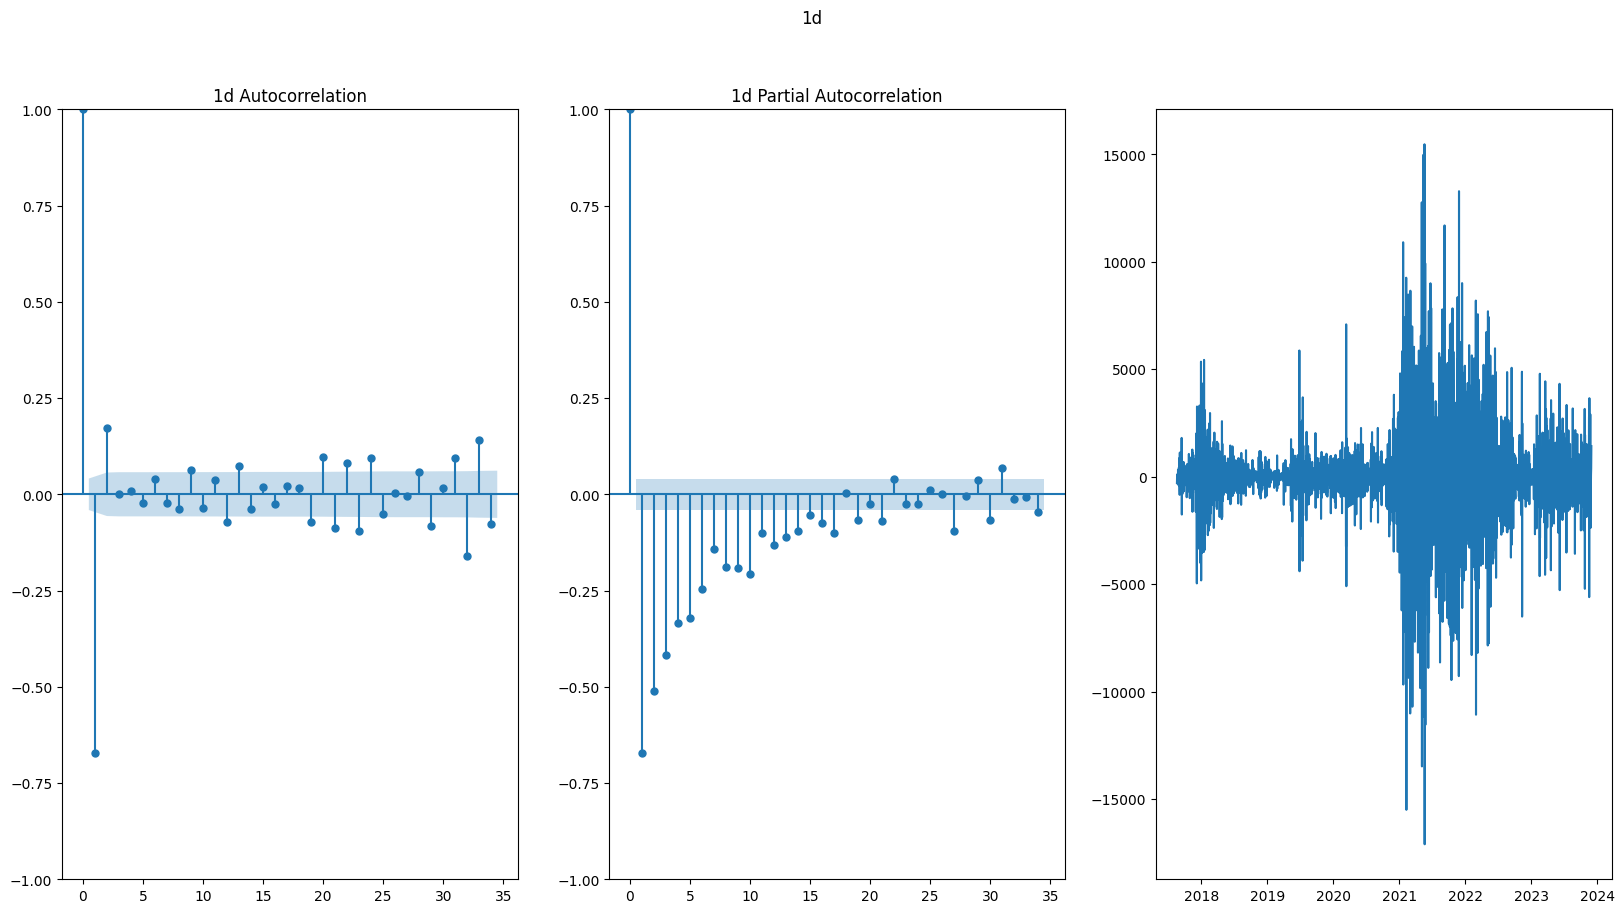

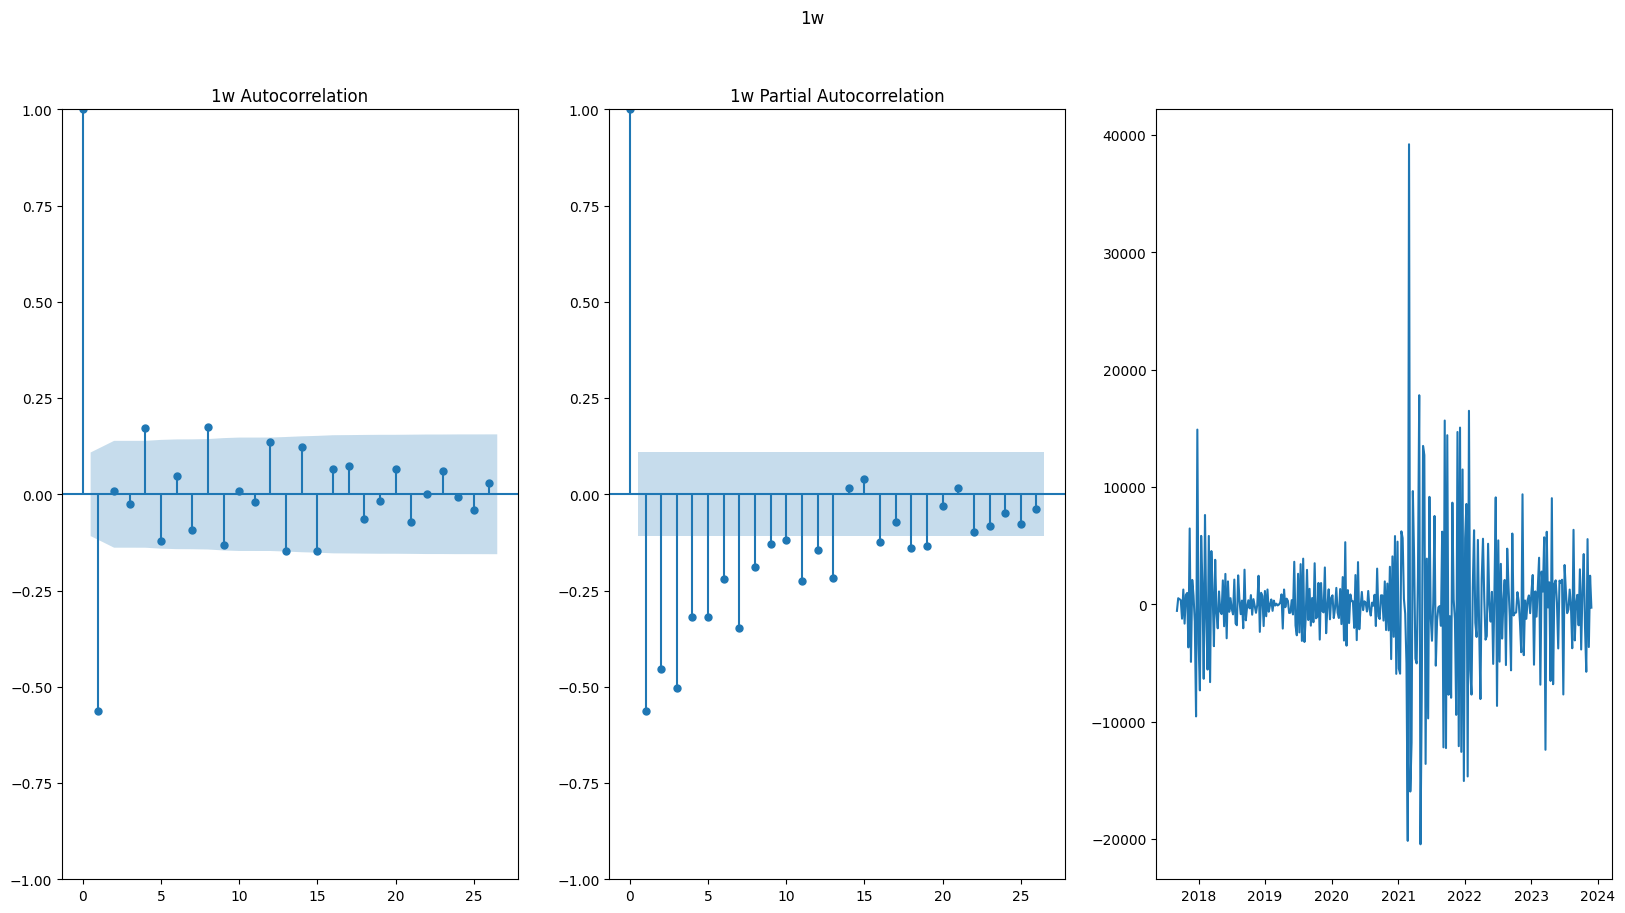

In [30]:
# 3 order differencing
for key, value in data_arima.items():
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    val = value.diff().diff().diff().dropna()
    plot_acf(val, ax=axes[0], title=f"{key} Autocorrelation")
    plot_pacf(val, ax=axes[1], title=f"{key} Partial Autocorrelation")
    axes[2].plot(val, label=f"{key} Original")
    fig.suptitle(key)
    plt.show()

For 1d and 1w timeframes we can see that 1 order differencing is the best, but for 1h we can't choose the best one for now because of high autocorrelation and partial autocorrelation, but with higher ordering it is bettering, so let's try to more order differencing for 1h timeframe.

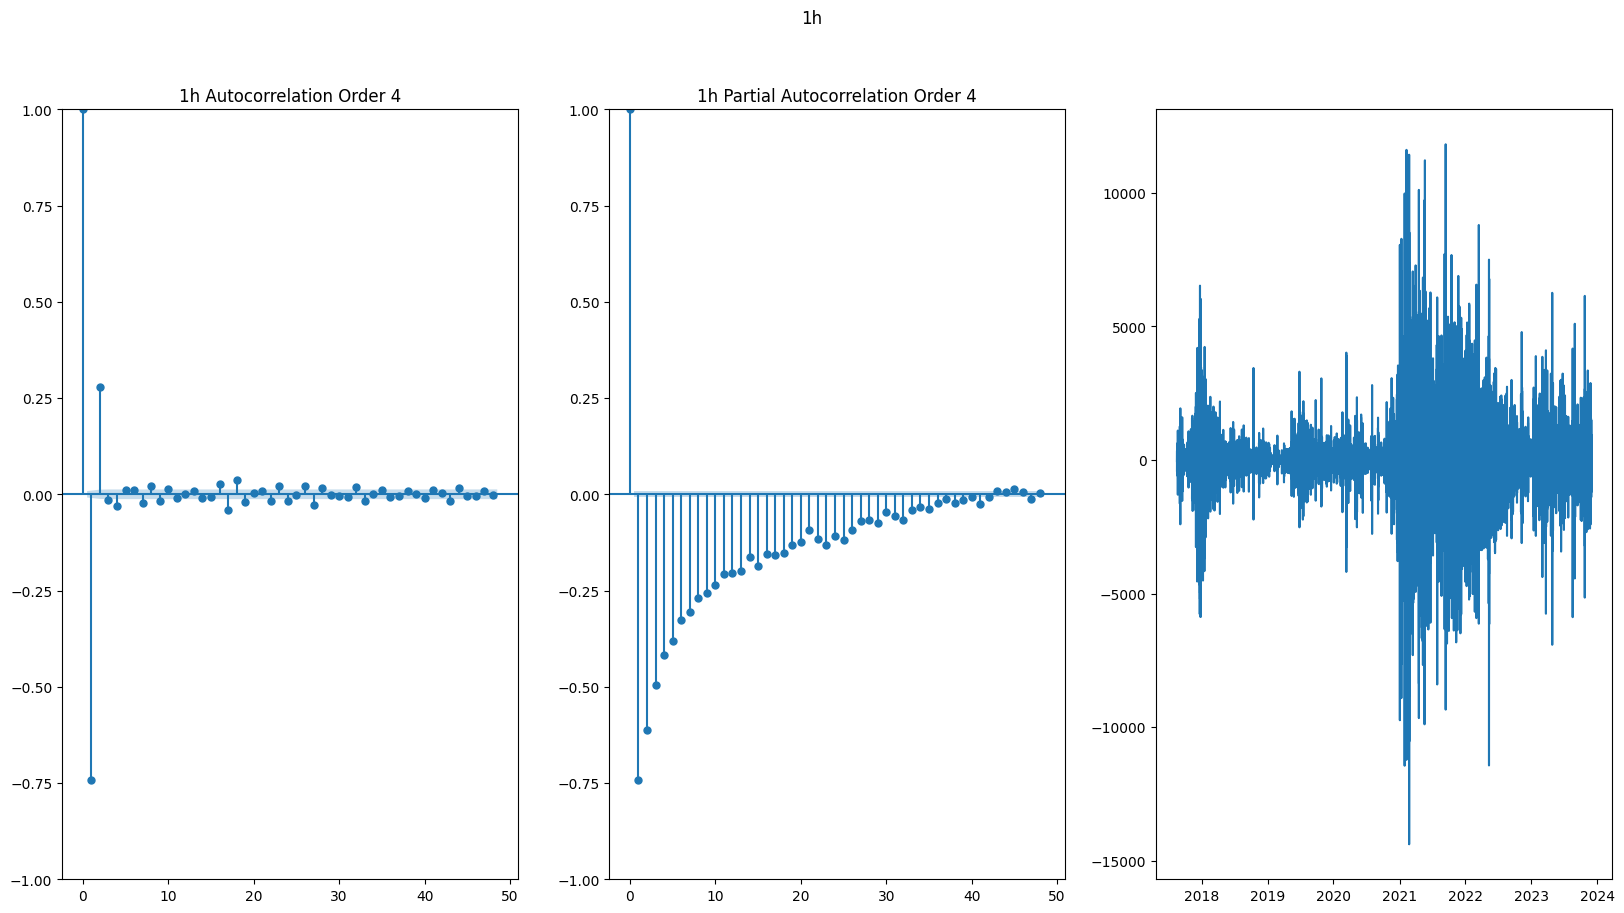

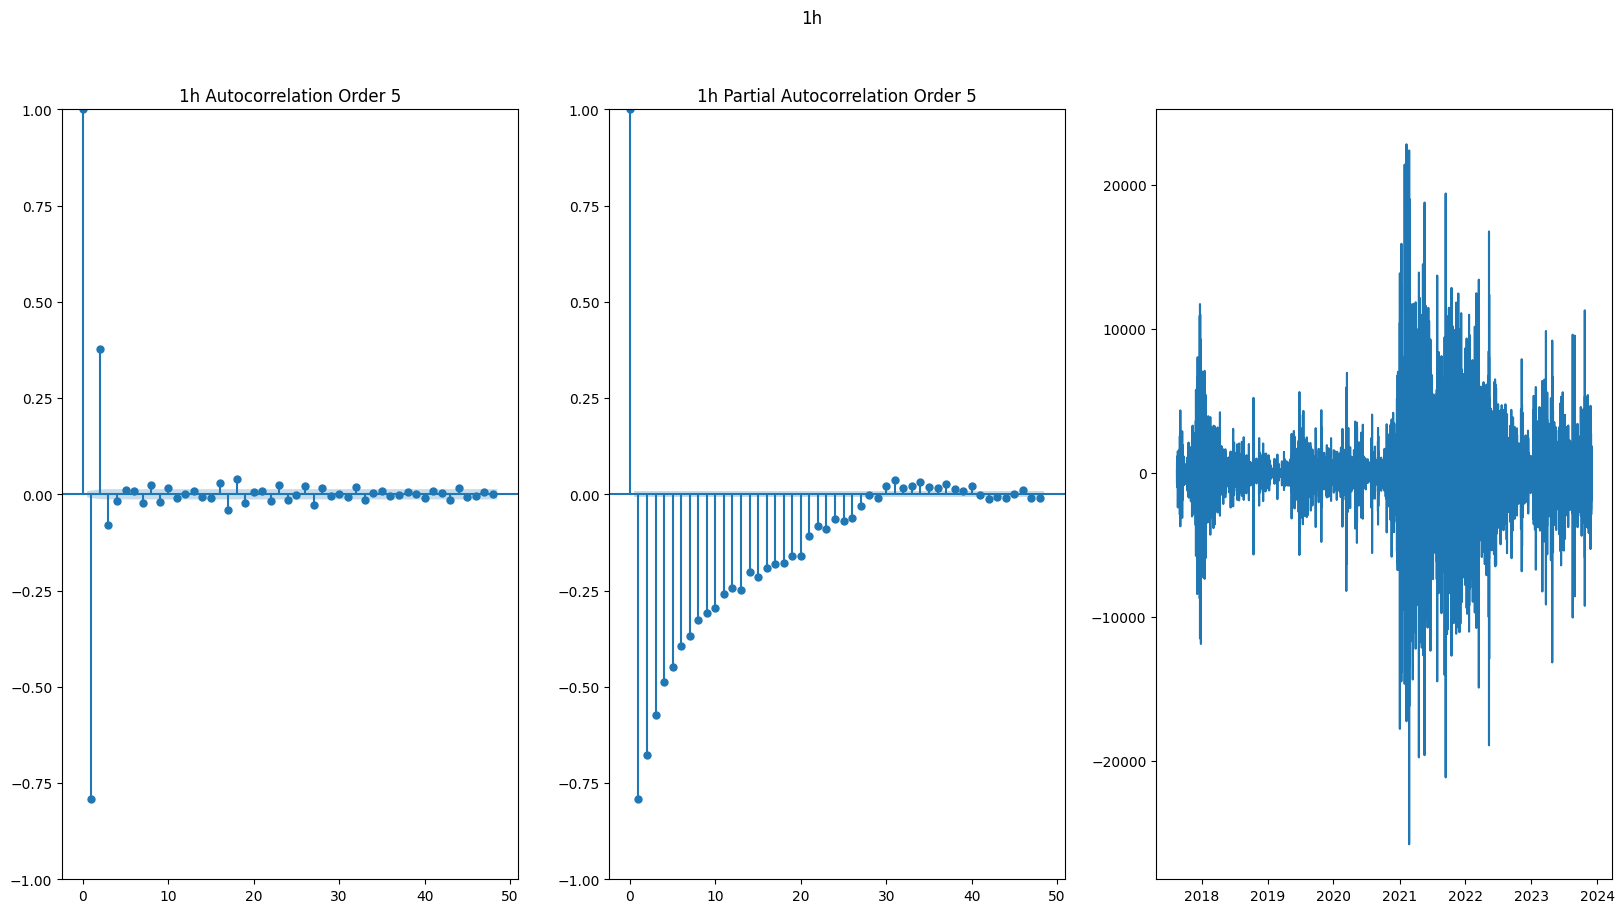

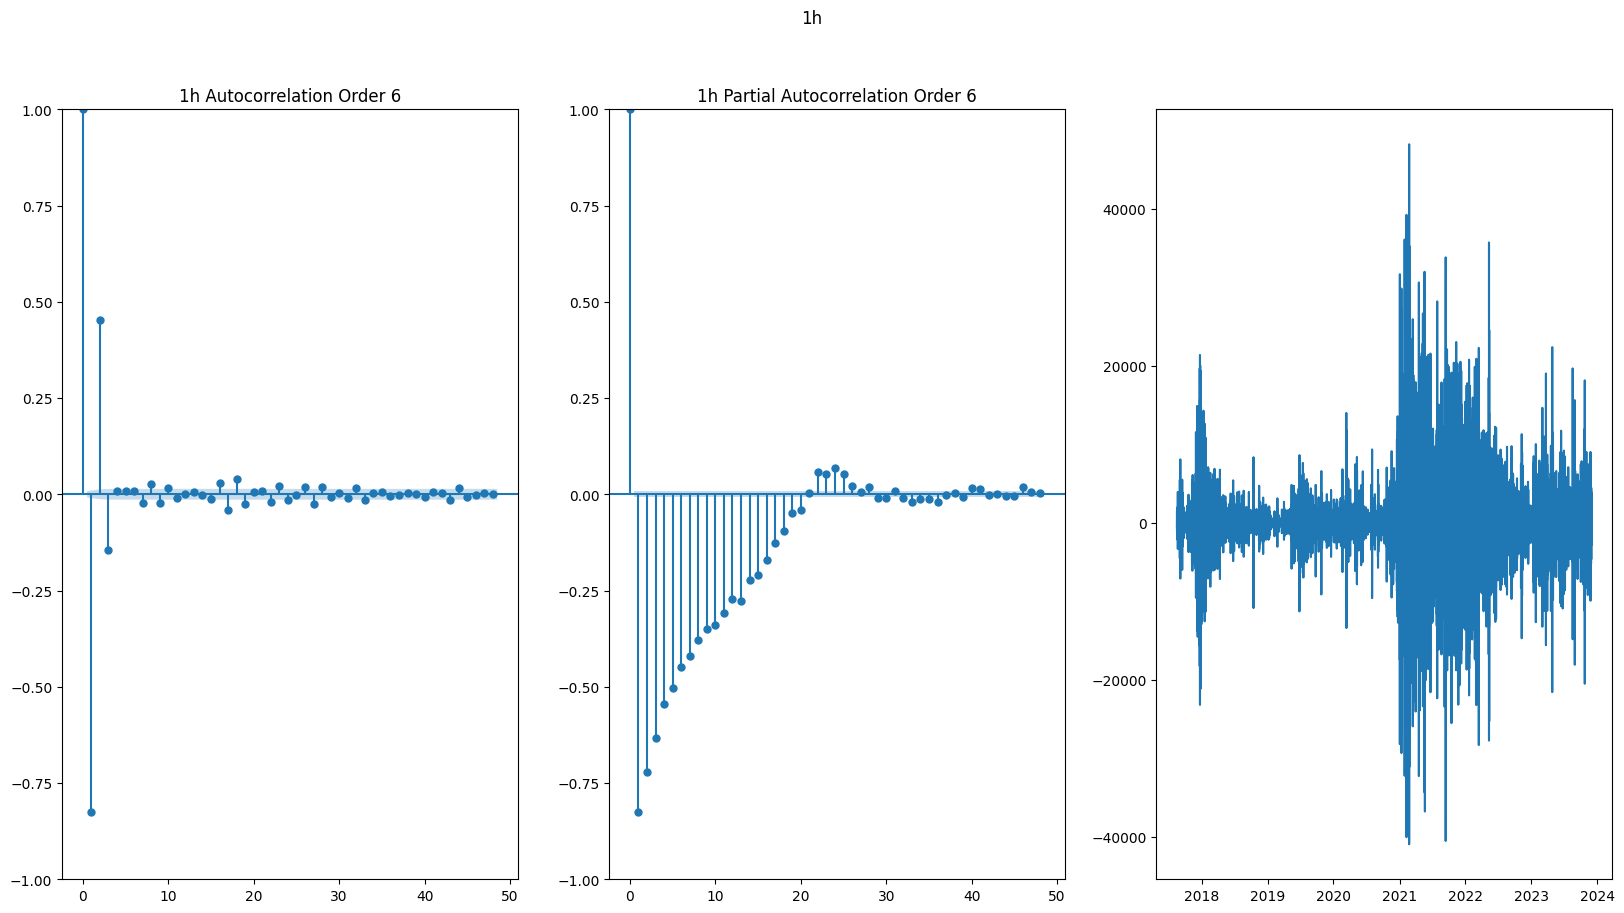

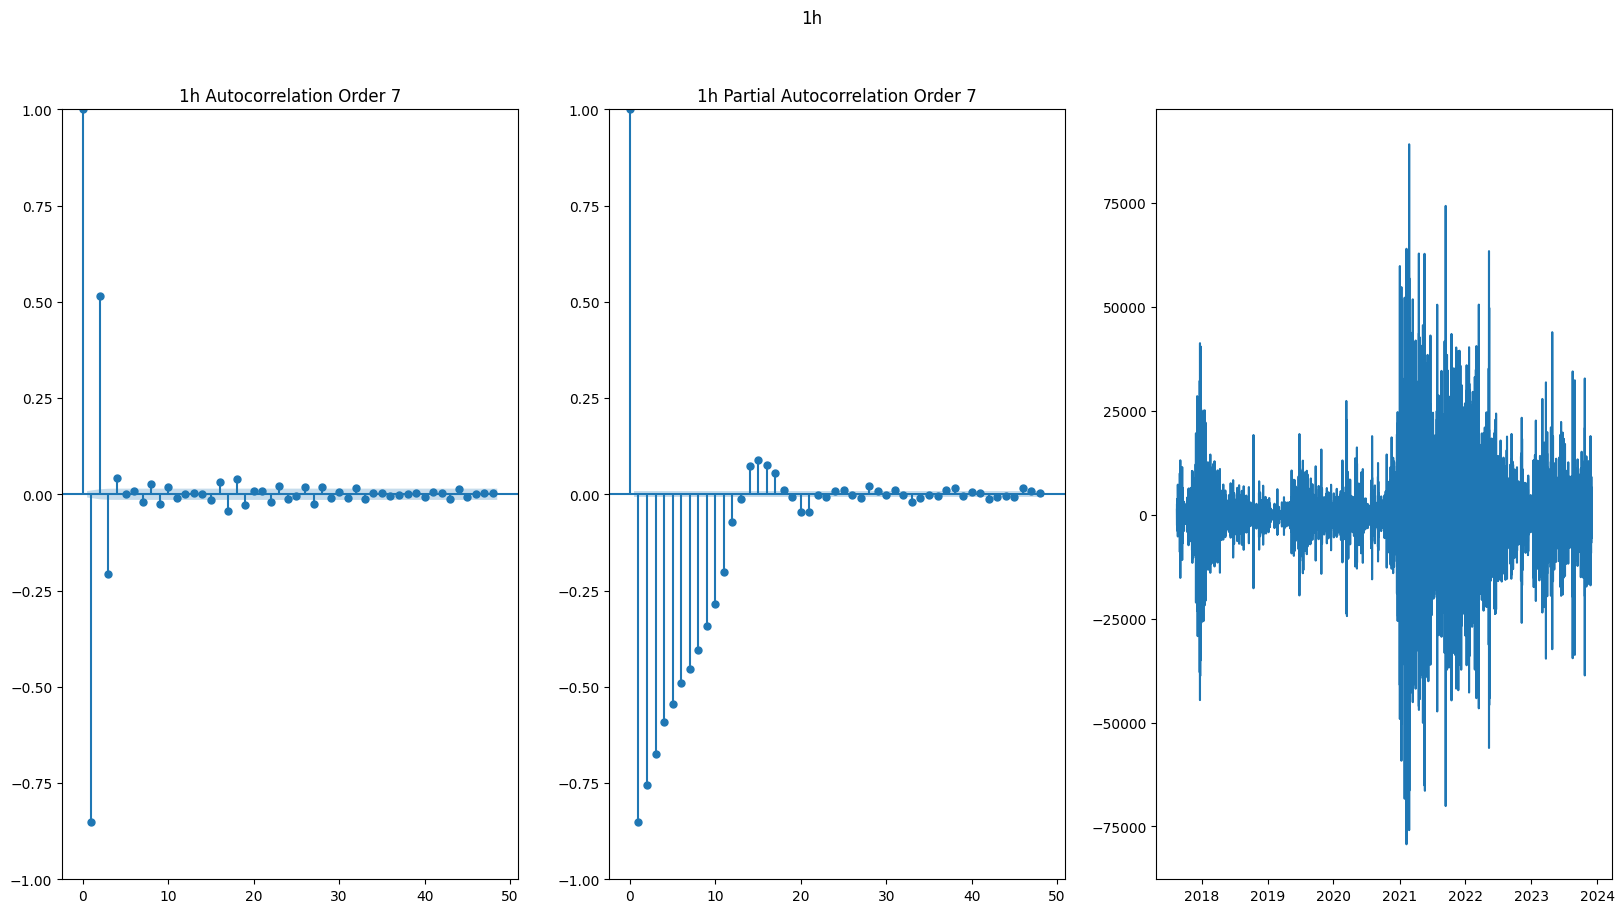

In [31]:
# 4, 5, 6, 7 order differencing for 1h timeframe
val = data_arima["1h"].diff().diff().diff().dropna()
for i in range(4, 8):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    val = val.diff().dropna()
    plot_acf(val, ax=axes[0], title=f"1h Autocorrelation Order {i}")
    plot_pacf(val, ax=axes[1], title=f"1h Partial Autocorrelation Order {i}")
    axes[2].plot(val, label=f"1h Original Order {i}")
    fig.suptitle(f"1h")
    plt.show()

Hm, after 3 order differencing we can see that autocorrelation and partial autocorrelation are not decreasing, so we will use 3 order differencing for 1h timeframe.

Also we can describe p and q parameters, on order of differencing
1h: p = 4, q = 3 
We have 3 big lags in autocorrelation and 4 big lags in partial autocorrelation (all other closer to mean)

1d: p = 1, q = 1
We have 1 big lag in autocorrelation and 1 big lag in partial autocorrelation

1w: p = 3, q = 3
We have 3 big lags in autocorrelation and 3 big lags in partial autocorrelation

Let's try other tests for stationarity

In [32]:
from statsmodels.tsa.stattools import adfuller

for key, value in data_arima.items():
    val1 = value.diff().dropna()
    val2 = value.diff().diff().dropna()
    val3 = value.diff().diff().diff().dropna()
    result0 = adfuller(value)
    result1 = adfuller(val1)
    result2 = adfuller(val2)
    result3 = adfuller(val3)
    print(f"{key} Original: {result0[1]}, 1: {result1[1]}, 2: {result2[1]}, 3: {result3[1]}")

1h Original: 0.5784494514777645, 1: 0.0, 2: 0.0, 3: 0.0
1d Original: 0.47117811975148505, 1: 1.5448804124044302e-11, 2: 4.5211638846455524e-29, 3: 0.0
1w Original: 0.6459357174401854, 1: 8.235220743740745e-05, 2: 9.858347896110431e-11, 3: 6.044477761994165e-13


ADF test shows that we should use 0 order for 1h, 0 order for 1d and 1 order for 1w

And now we can train ARIMA models

1h
1d
1w


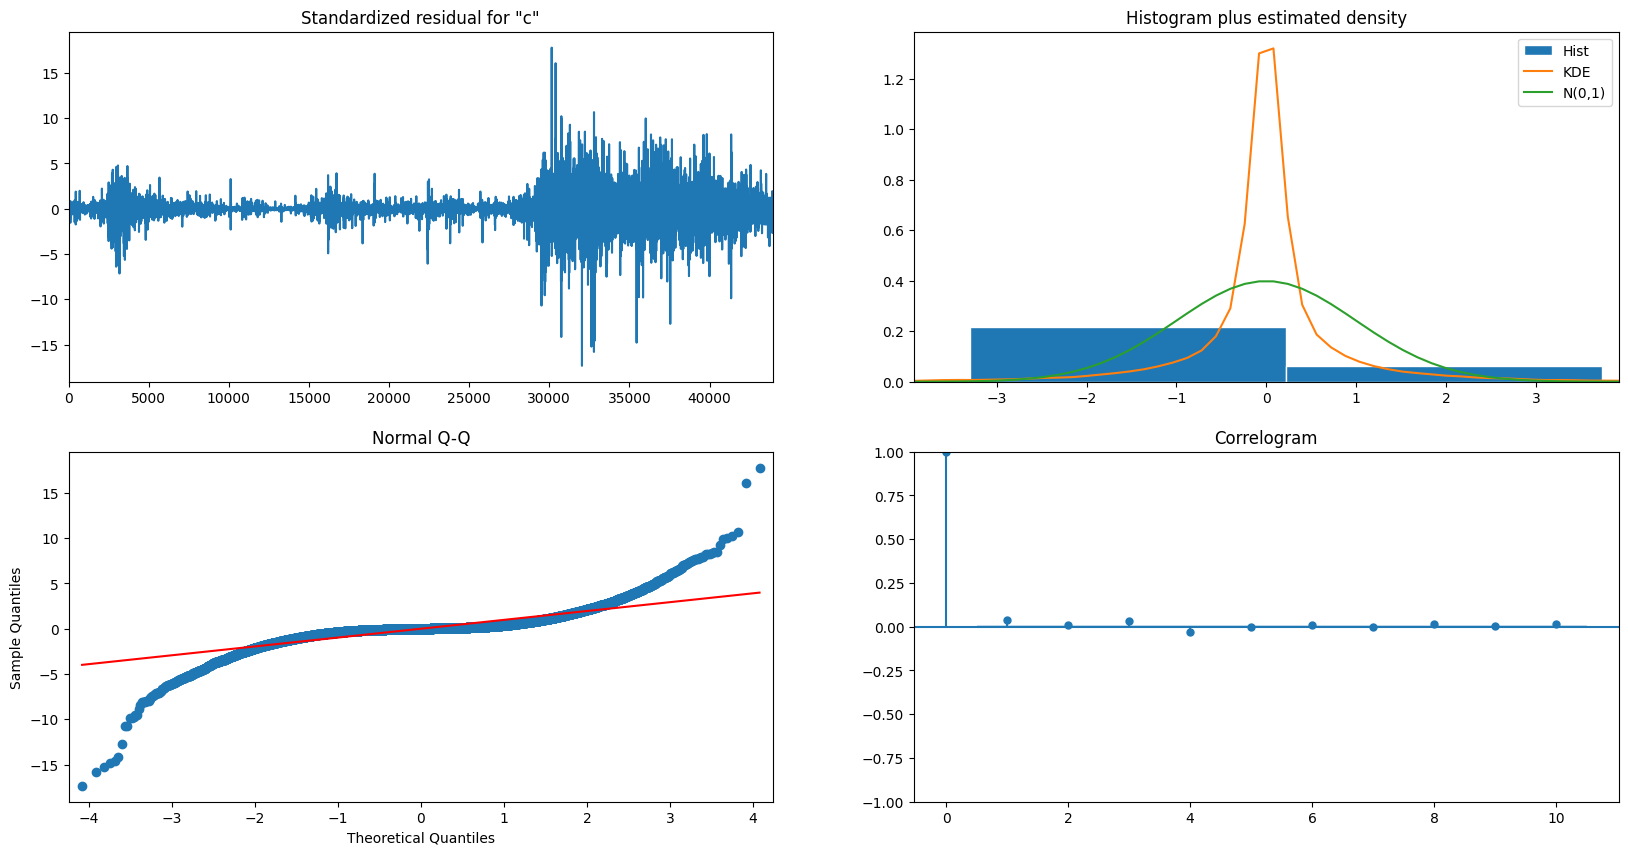

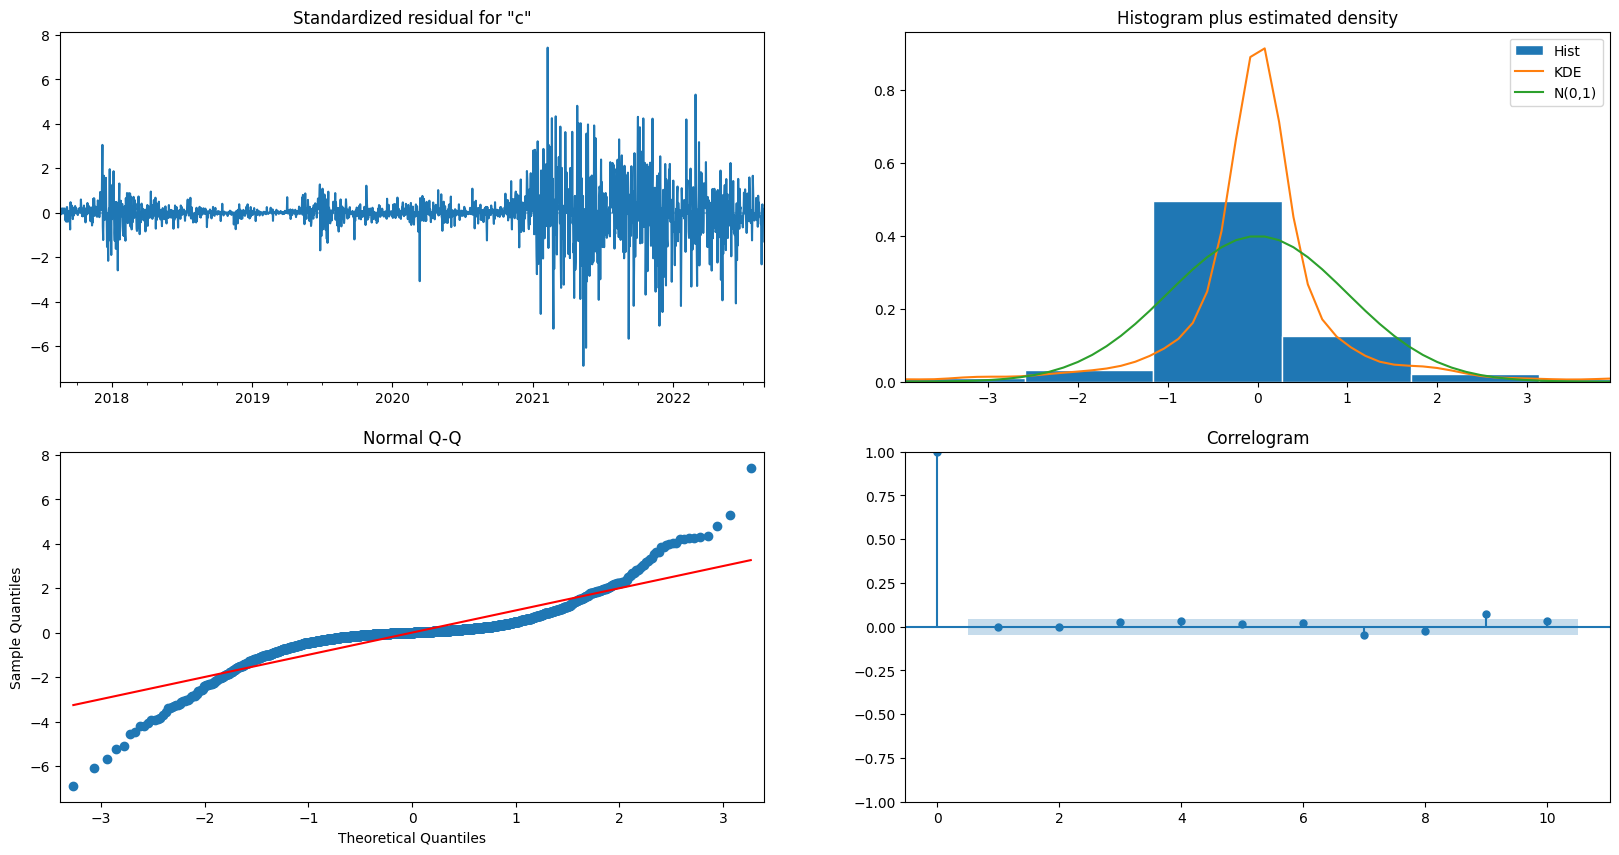

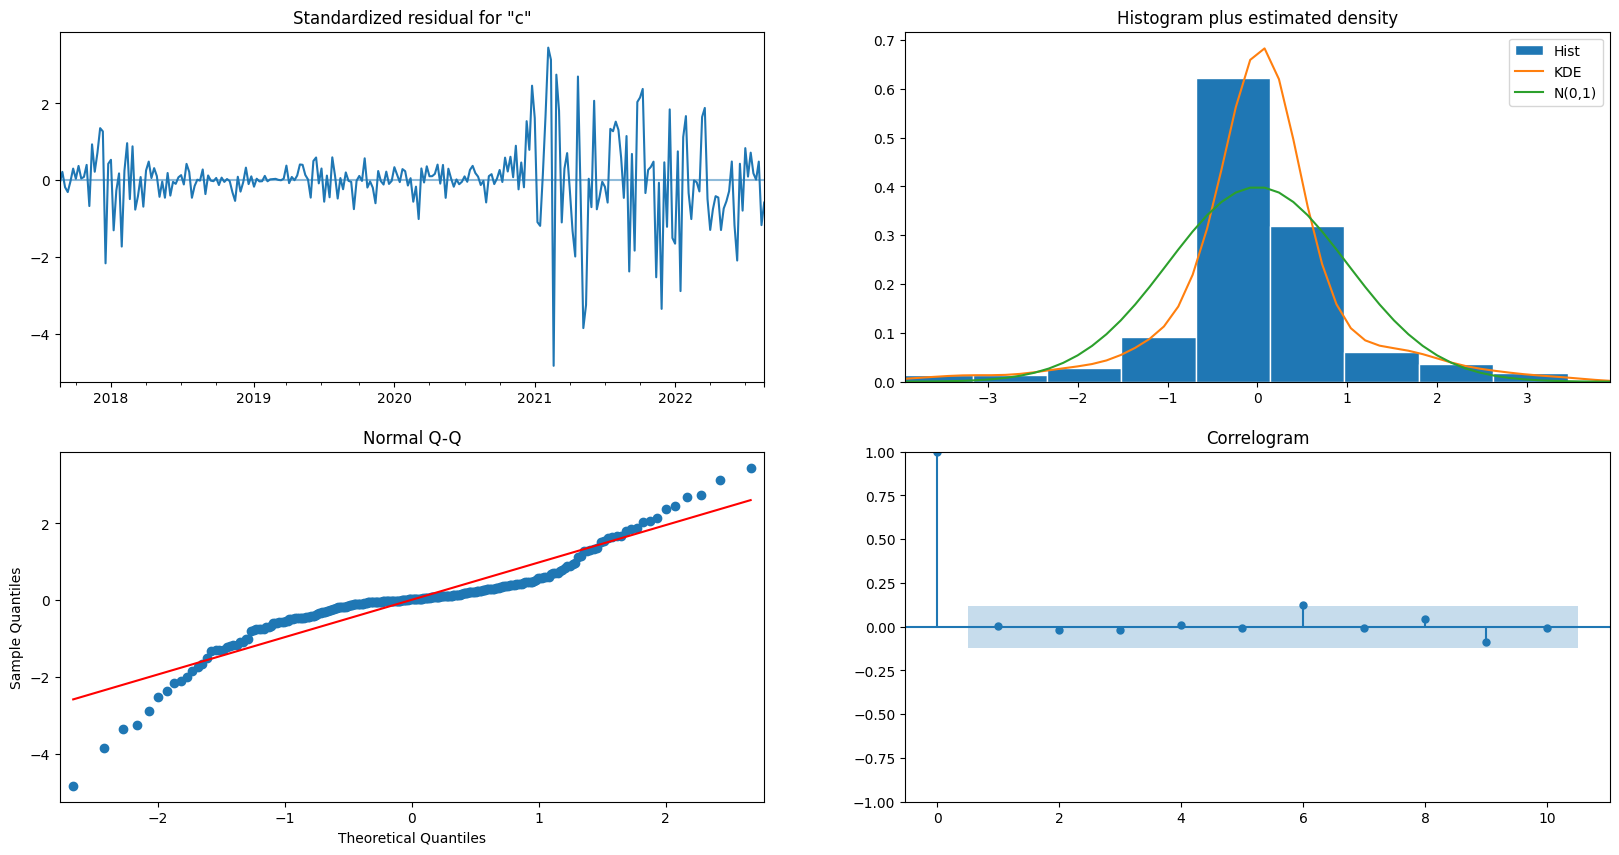

In [33]:
# Split data into train and test
PERCENT_TRAIN = 0.8
train_arima = {key: value[:int(value.shape[0] * PERCENT_TRAIN)] for key, value in data_arima.items()}
test_arima = {key: value[int(value.shape[0] * PERCENT_TRAIN):] for key, value in data_arima.items()}

# Train ARIMA models
from statsmodels.tsa.arima.model import ARIMA

models = {}
predictions = {}

arima_configs = {
    "1h": {
        "order": (4, 3, 3)
    },
    "1d": {
        "order": (1, 1, 1)
    },
    "1w": {
        "order": (3, 1, 3)
    }
}

for key, value in train_arima.items():
    # Fit the ARIMA model
    model = ARIMA(value, **arima_configs[key])
    model_fit = model.fit()
    models[key] = model_fit

    # Make predictions
    forecast_steps = len(test_arima[key])
    forecast = model_fit.forecast(steps=forecast_steps)
    predictions[key] = forecast
    
    # Plots
    print(key)
    model_fit.plot_diagnostics(figsize=(20, 10))

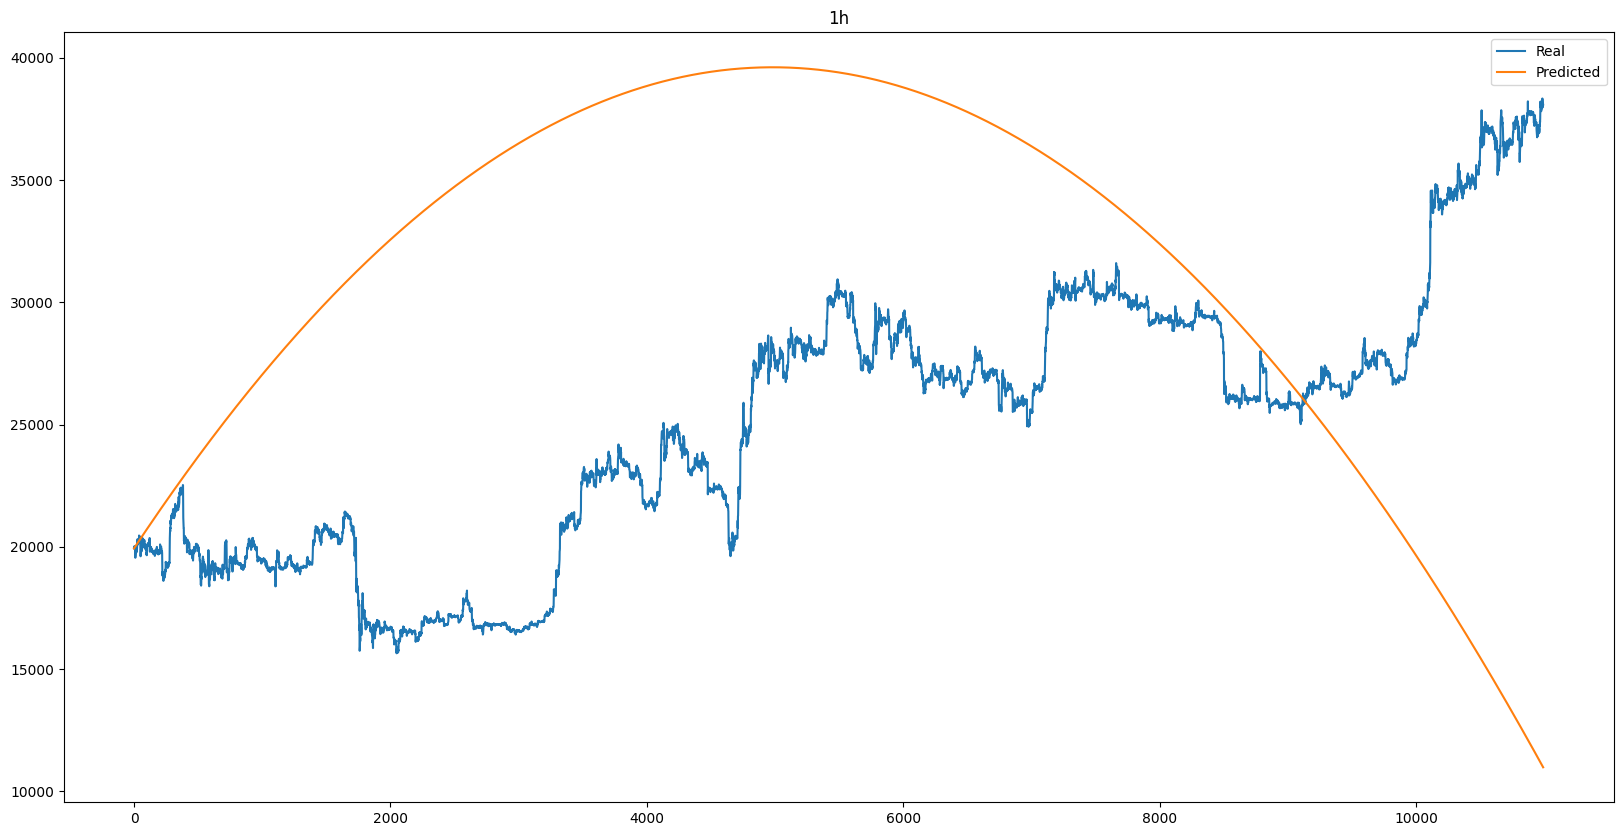

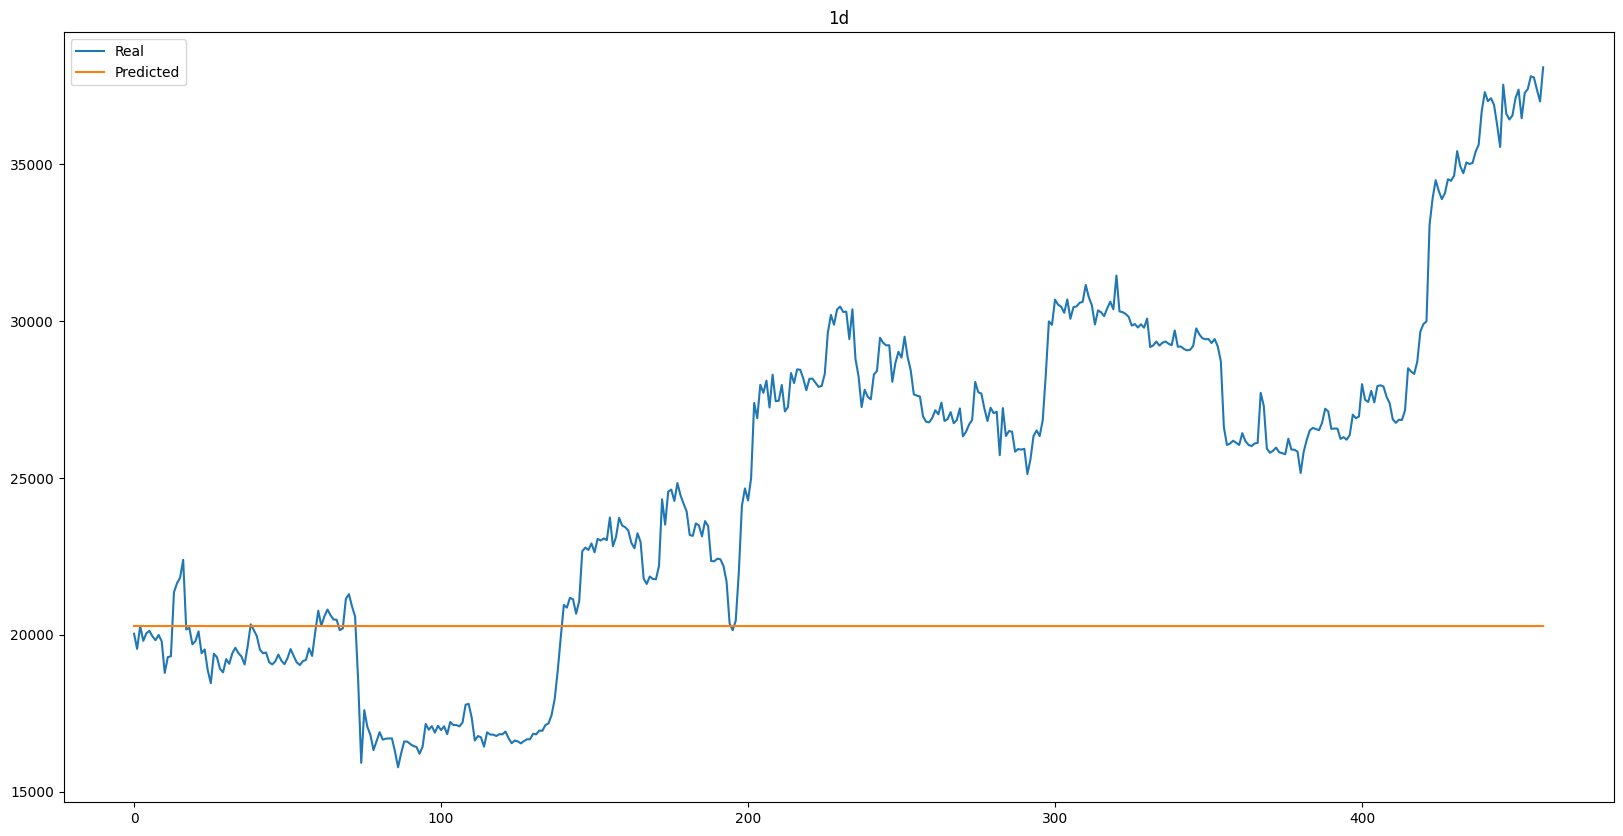

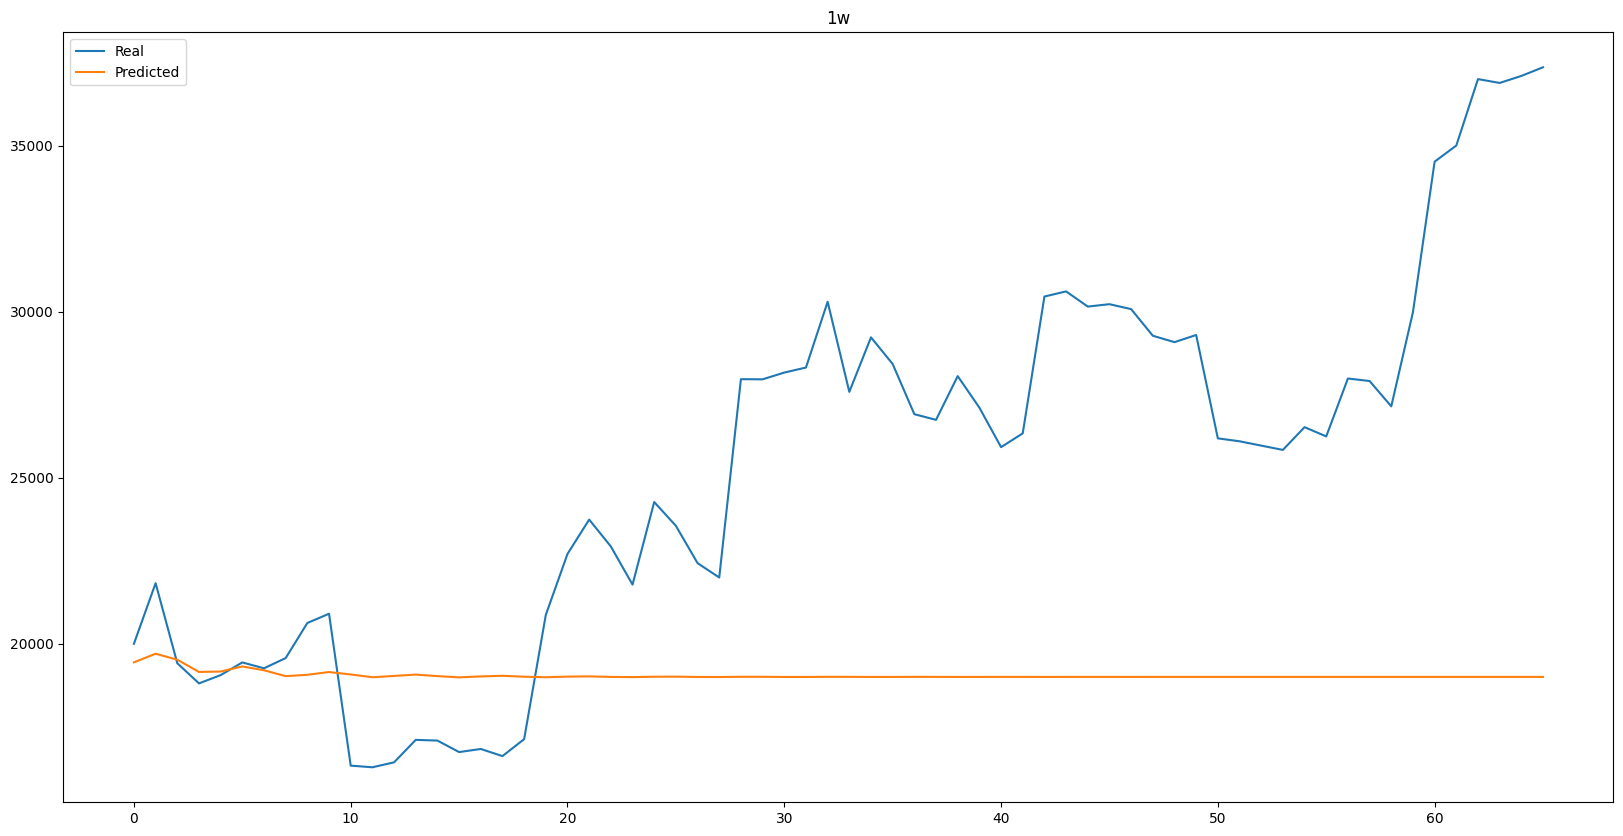

In [34]:
# Plot predictions and real values
for key, value in predictions.items():
    plt.figure(figsize=(20, 10))
    plt.plot(test_arima[key].values, label="Real")
    plt.plot(value.values, label="Predicted")
    plt.title(key)
    plt.legend()
    plt.show()

Sometimes it crosses real values =)

## Exponential smoothing

In [35]:
# Data preparation for exponential smoothing (need only close price)
data_es = {key: value["close"] for key, value in data.items()}

Here we will use different models:
1. Simple exponential smoothing
2. Holt's linear trend method
3. Holt-Winters' method

All of them are using exponential smoothing, but with different parameters

In [36]:
# Split data into train and test
PERCENT_TRAIN = 0.8
train_es = {key: value[:int(value.shape[0] * PERCENT_TRAIN)] for key, value in data_es.items()}
test_es = {key: value[int(value.shape[0] * PERCENT_TRAIN):] for key, value in data_es.items()}

# Train exponential smoothing models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

models = {}
predictions = {}

In [38]:
# Simple exponential smoothing
for key, value in train_es.items():
    # Fit the model
    model = SimpleExpSmoothing(value)
    model_fit = model.fit()
    models[key] = model_fit

    # Make predictions
    forecast_steps = len(test_es[key])
    forecast = model_fit.forecast(steps=forecast_steps)
    predictions[key] = forecast

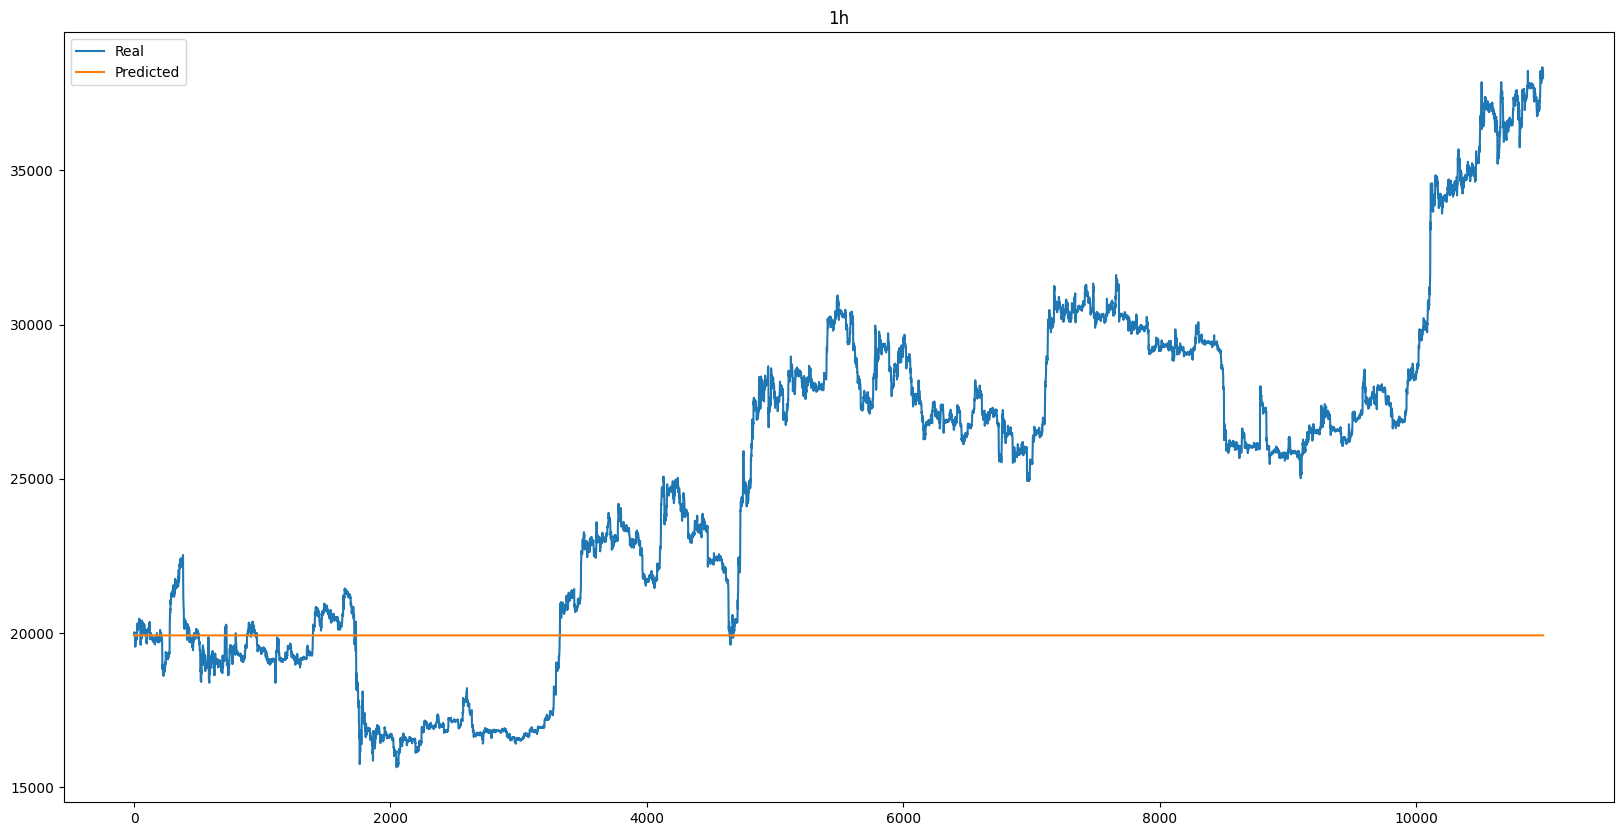

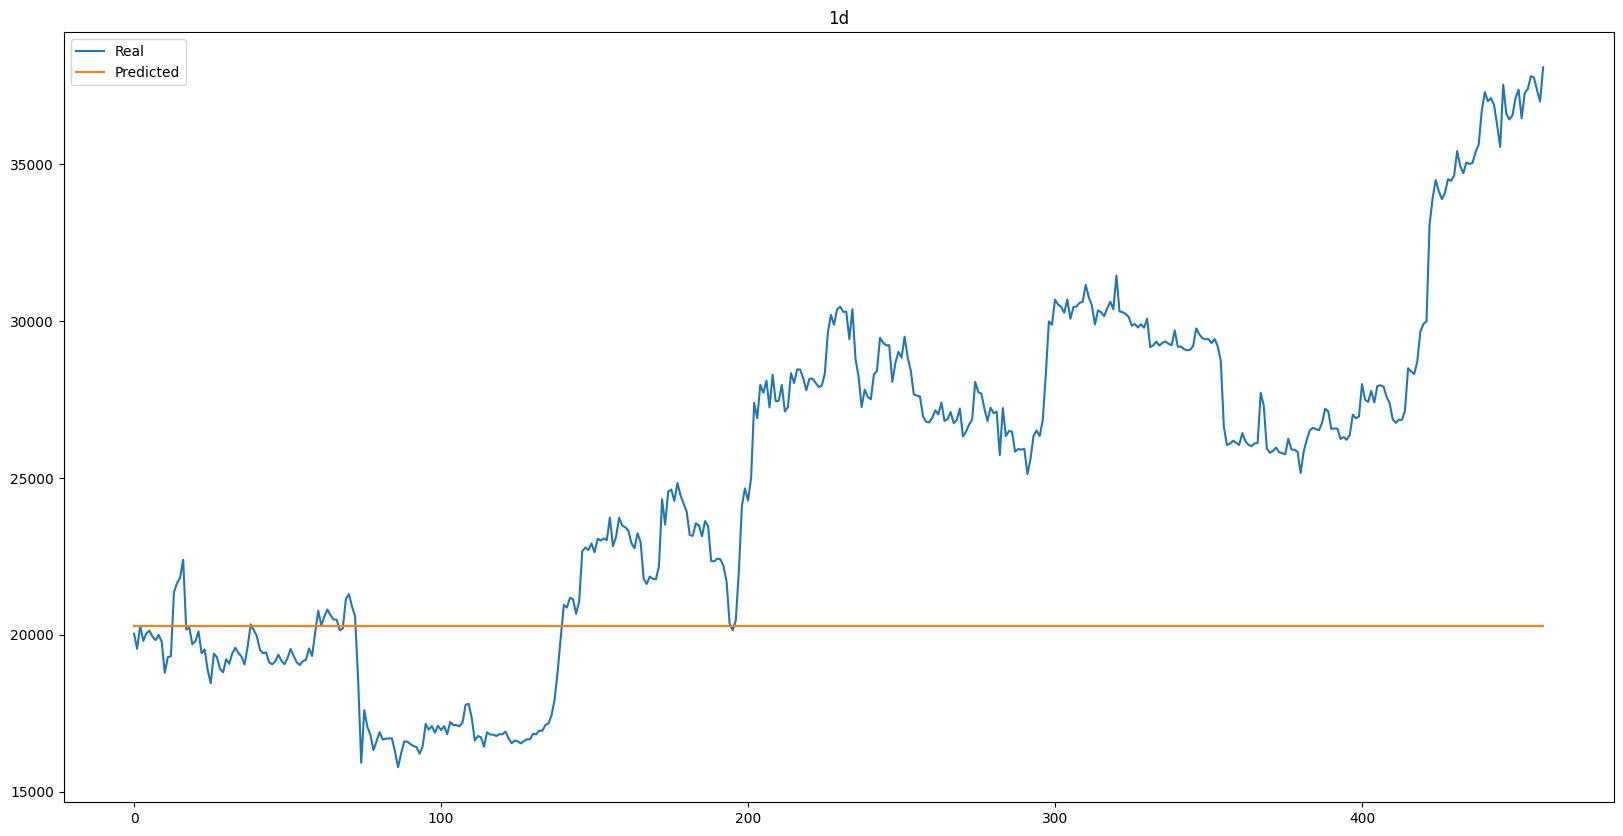

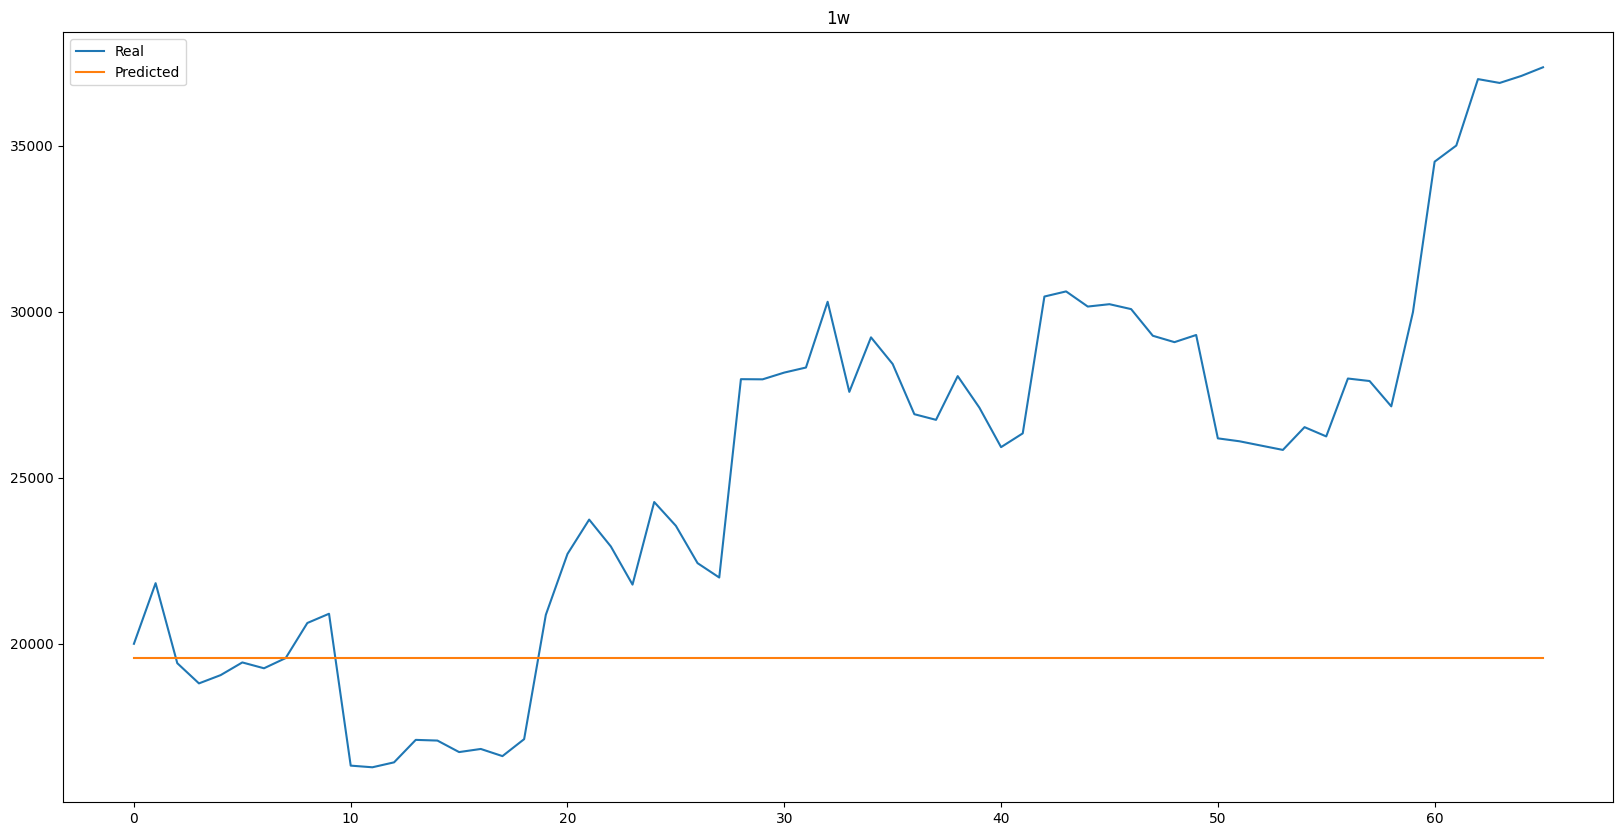

In [39]:
# Plot predictions and real values for simple exponential smoothing
for key, value in predictions.items():
    plt.figure(figsize=(20, 10))
    plt.plot(test_es[key].values, label="Real")
    plt.plot(value.values, label="Predicted")
    plt.title(key)
    plt.legend()
    plt.show()

In [41]:
# Holt's linear trend method
for key, value in train_es.items():
    # Fit the model
    model = Holt(value)
    model_fit = model.fit()
    models[key] = model_fit

    # Make predictions
    forecast_steps = len(test_es[key])
    forecast = model_fit.forecast(steps=forecast_steps)
    predictions[key] = forecast

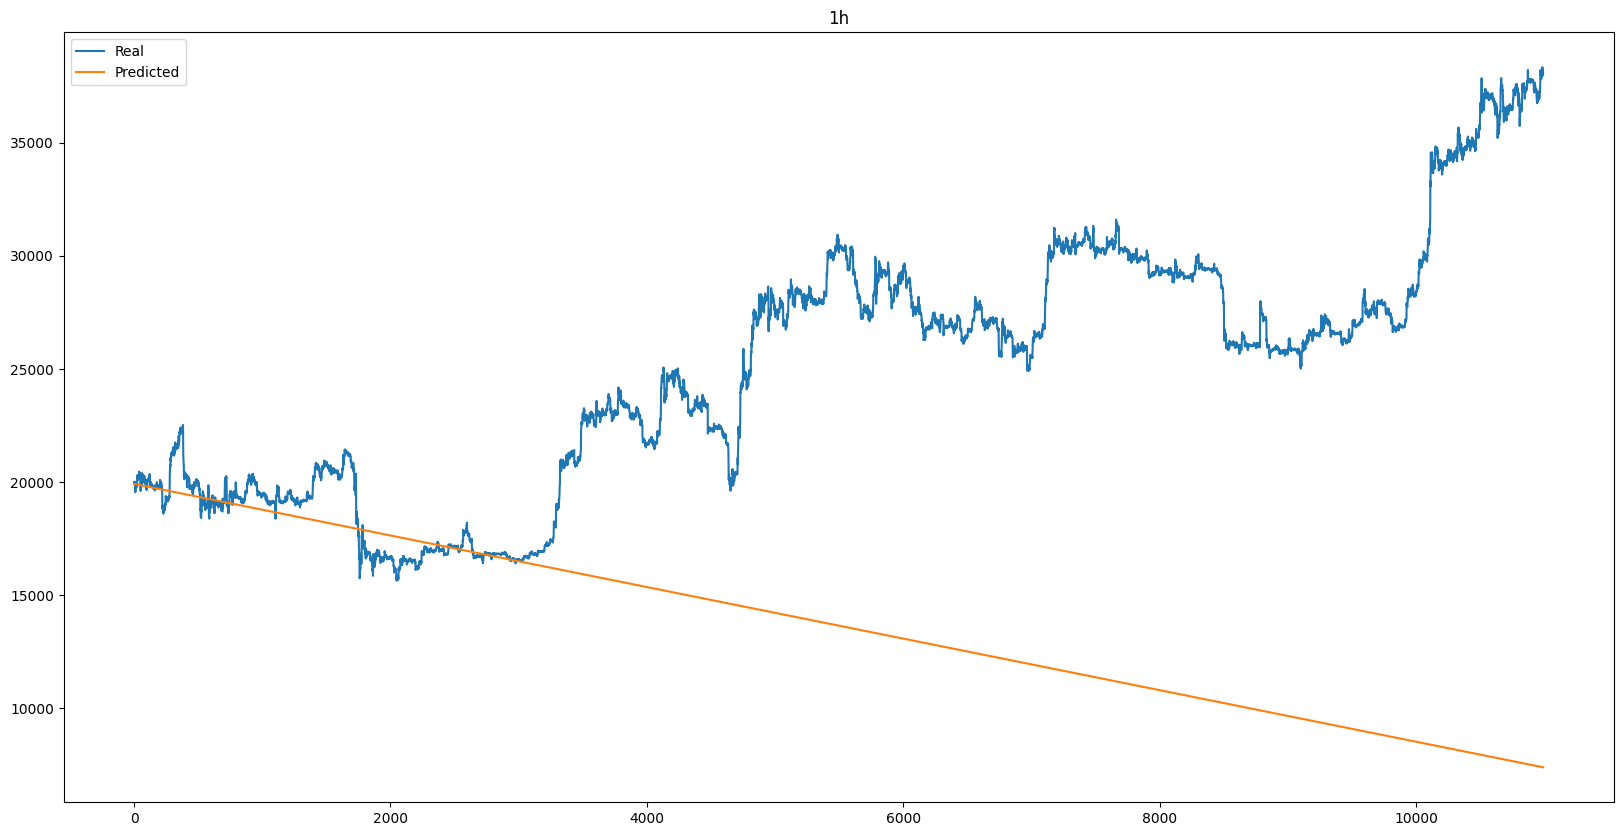

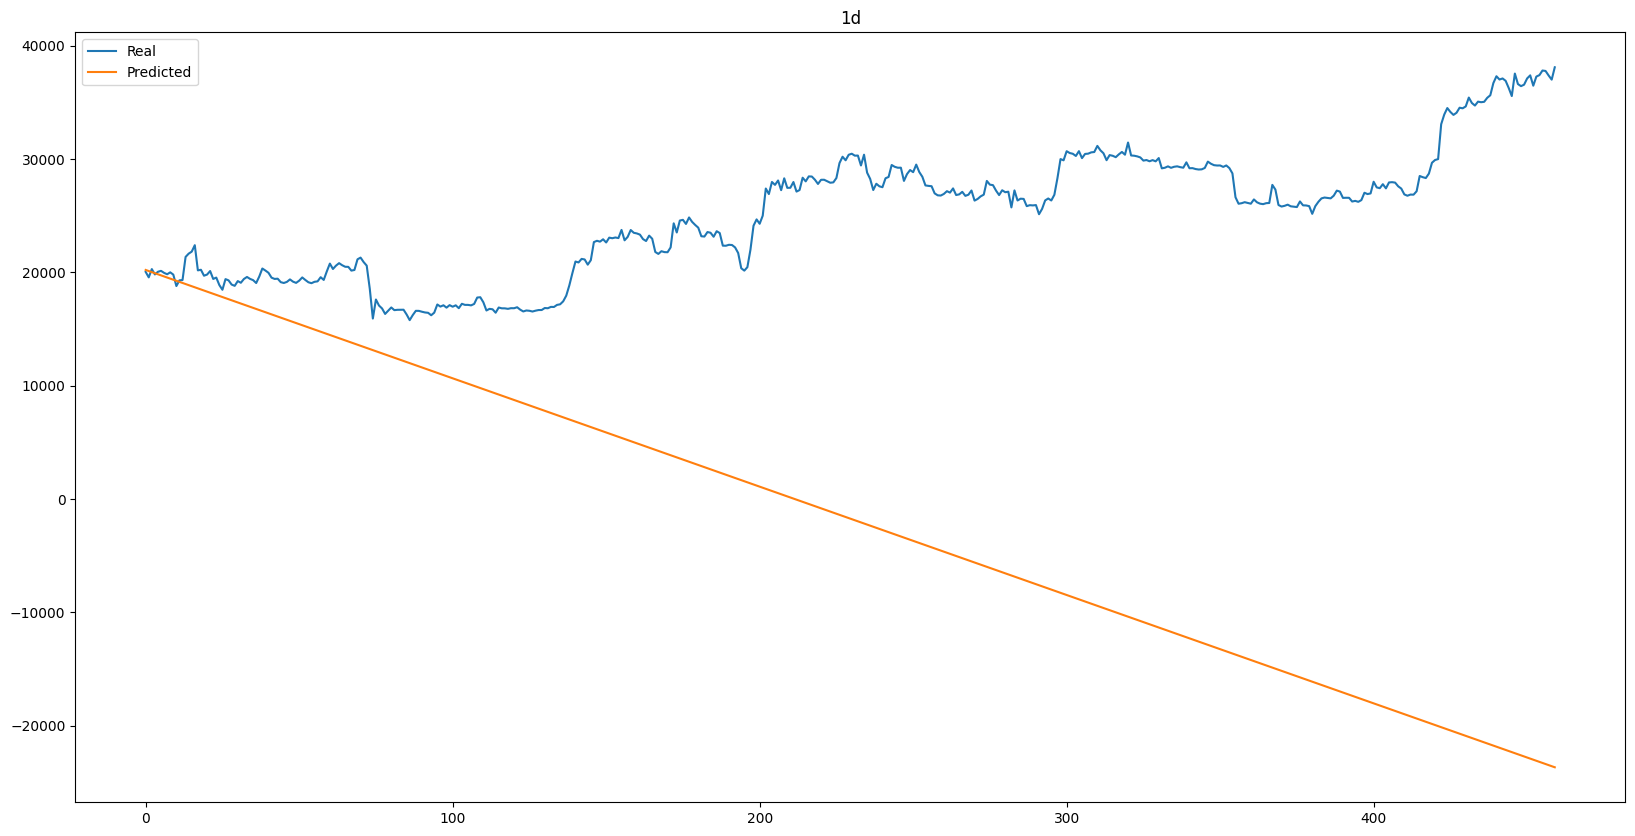

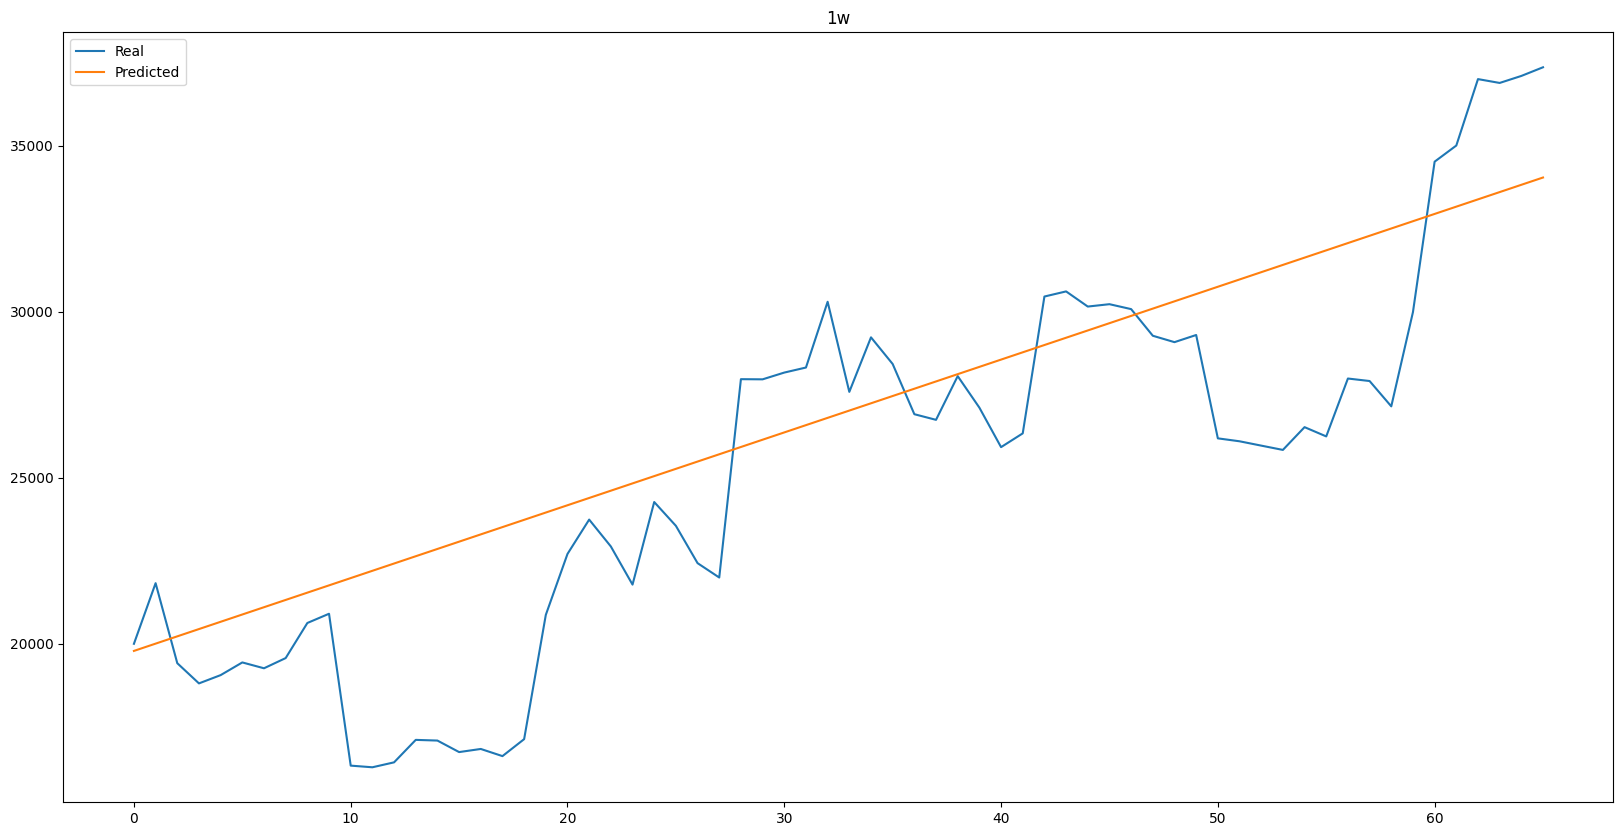

In [42]:
# Plot predictions and real values for Holt's linear trend method
for key, value in predictions.items():
    plt.figure(figsize=(20, 10))
    plt.plot(test_es[key].values, label="Real")
    plt.plot(value.values, label="Predicted")
    plt.title(key)
    plt.legend()
    plt.show()

It is better than simple exponential smoothing for 1w timeframe

In [43]:
# Holt-Winters' method
for key, value in train_es.items():
    # Fit the model
    model = ExponentialSmoothing(value)
    model_fit = model.fit()
    models[key] = model_fit

    # Make predictions
    forecast_steps = len(test_es[key])
    forecast = model_fit.forecast(steps=forecast_steps)
    predictions[key] = forecast

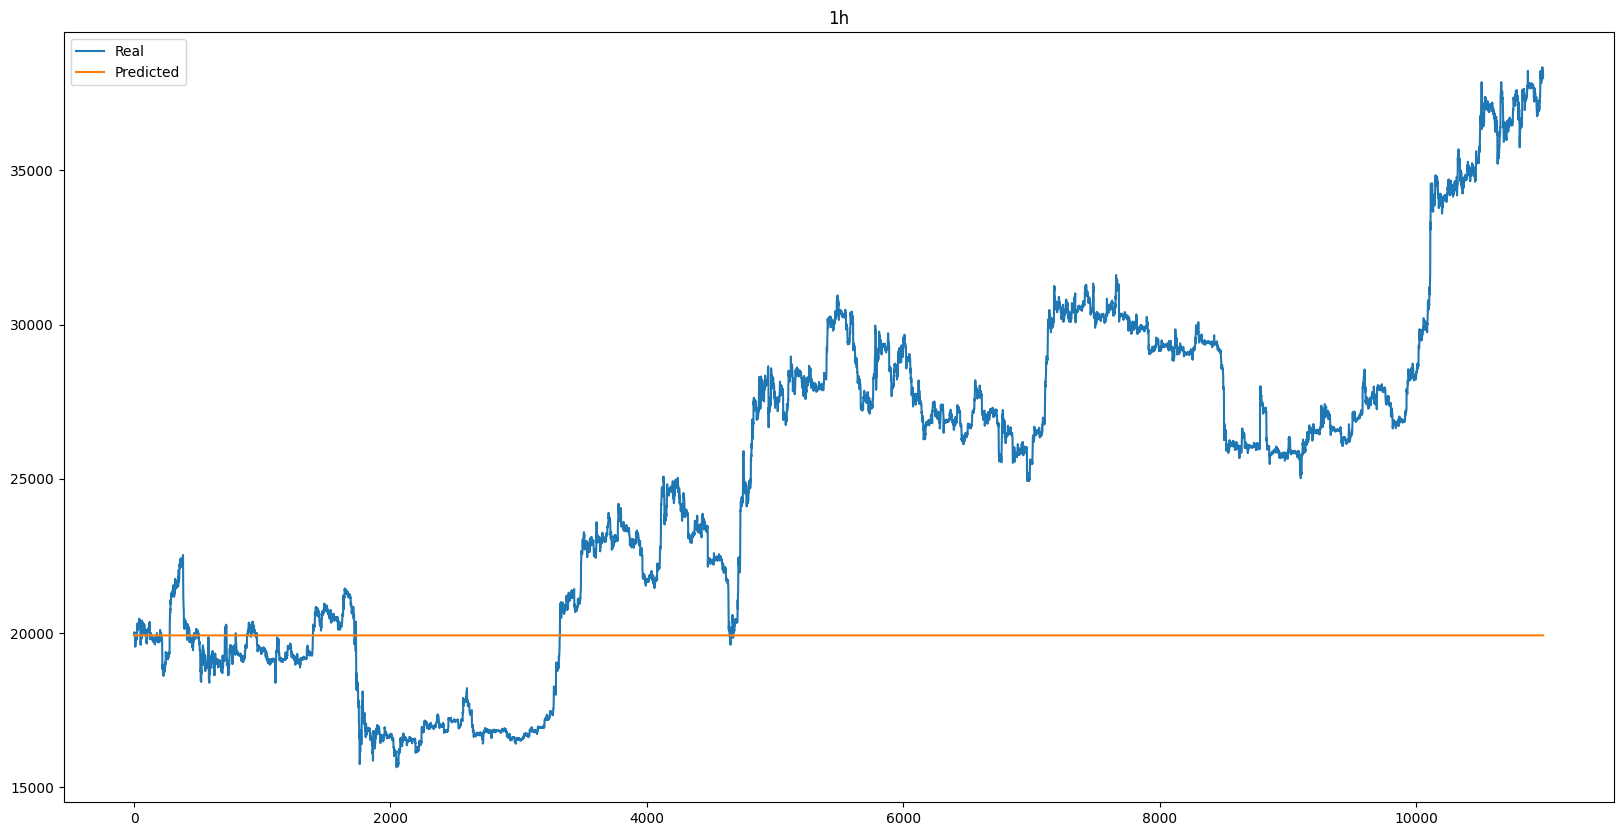

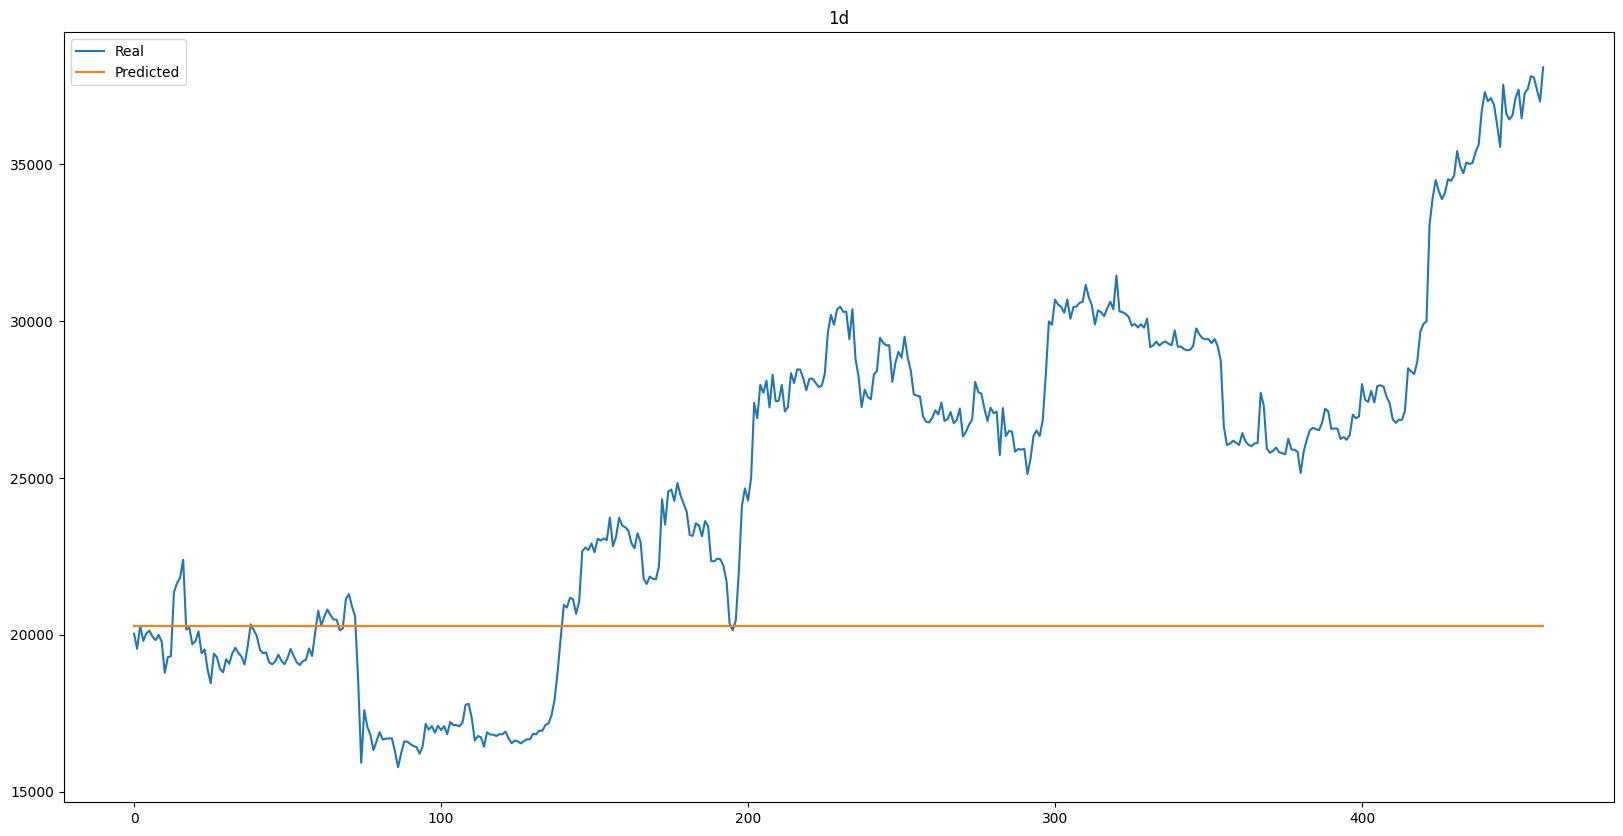

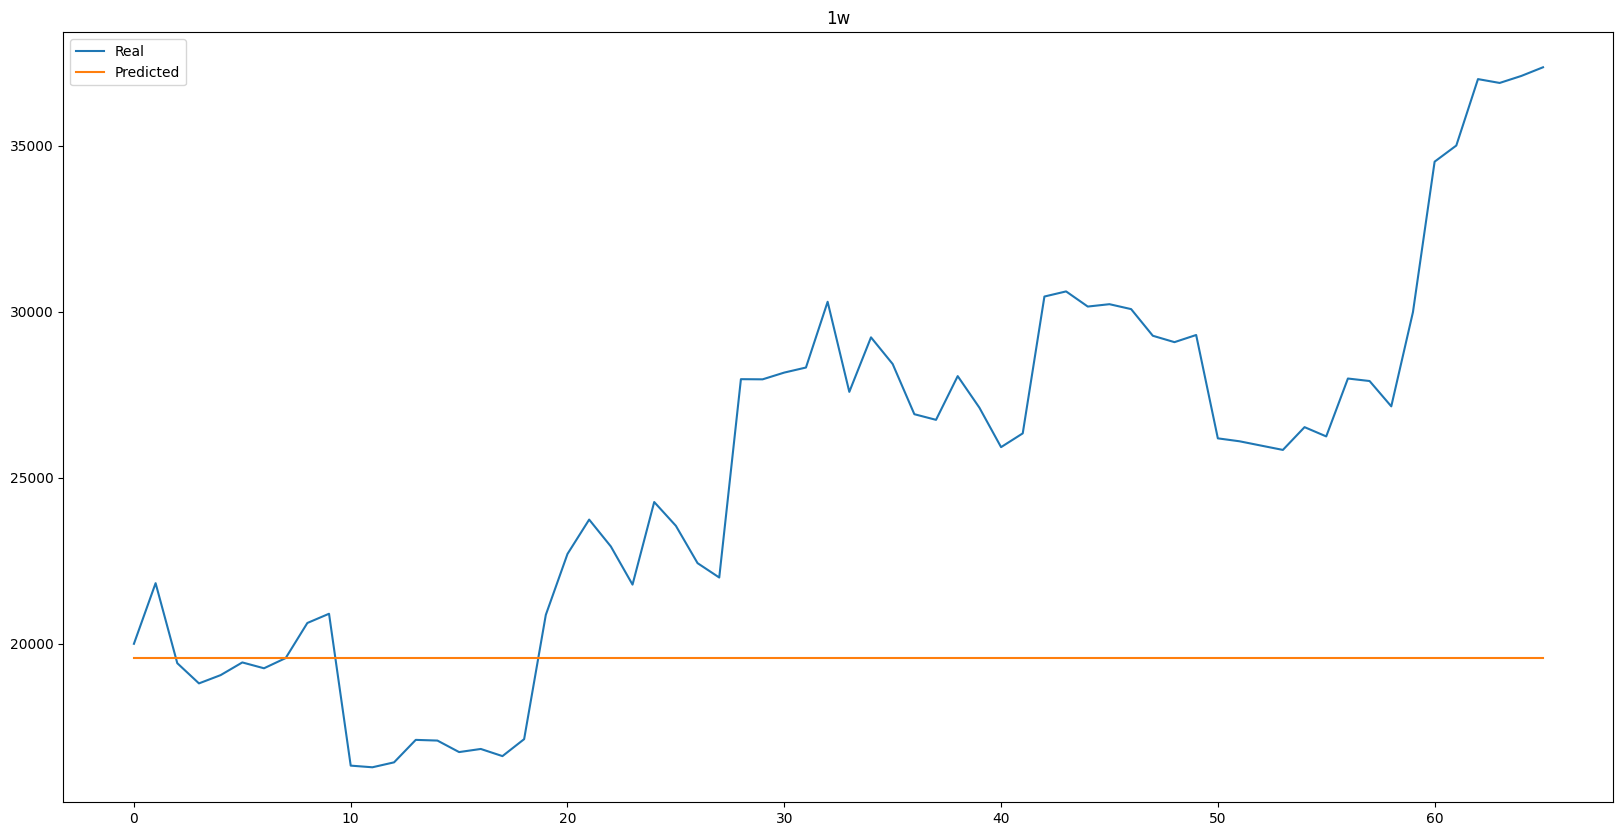

In [44]:
# Plot predictions and real values for Holt-Winters' method
for key, value in predictions.items():
    plt.figure(figsize=(20, 10))
    plt.plot(test_es[key].values, label="Real")
    plt.plot(value.values, label="Predicted")
    plt.title(key)
    plt.legend()
    plt.show()

Bad for all timeframes...

## Fourier analysis

In [54]:
# Data preparation for Fourier analysis (need only close price)
data_fourier = {key: value["close"] for key, value in data.items()}

In [55]:
# Split data into train and test

PERCENT_TRAIN = 0.8
train_fourier = {key: value[:int(value.shape[0] * PERCENT_TRAIN)] for key, value in data_fourier.items()}
test_fourier = {key: value[int(value.shape[0] * PERCENT_TRAIN):] for key, value in data_fourier.items()}


In [57]:
# Fourier analysis
from scipy.fft import fft, fftfreq

models = {}
predictions = {}

for key, value in train_fourier.items():
    # Fourier analysis
    yf = fft(value.values)
    xf = fftfreq(len(value), 1 / (24 if key == "1h" else 1 / (7 if key == "1w" else 1)))
    yf = yf[xf > 0]
    xf = xf[xf > 0]

    # Find max frequency
    max_freq = xf[yf.argmax()]

    # Make predictions
    forecast_steps = len(test_fourier[key].values)
    forecast = [yf[xf == max_freq][0] for _ in range(forecast_steps)]
    predictions[key] = forecast

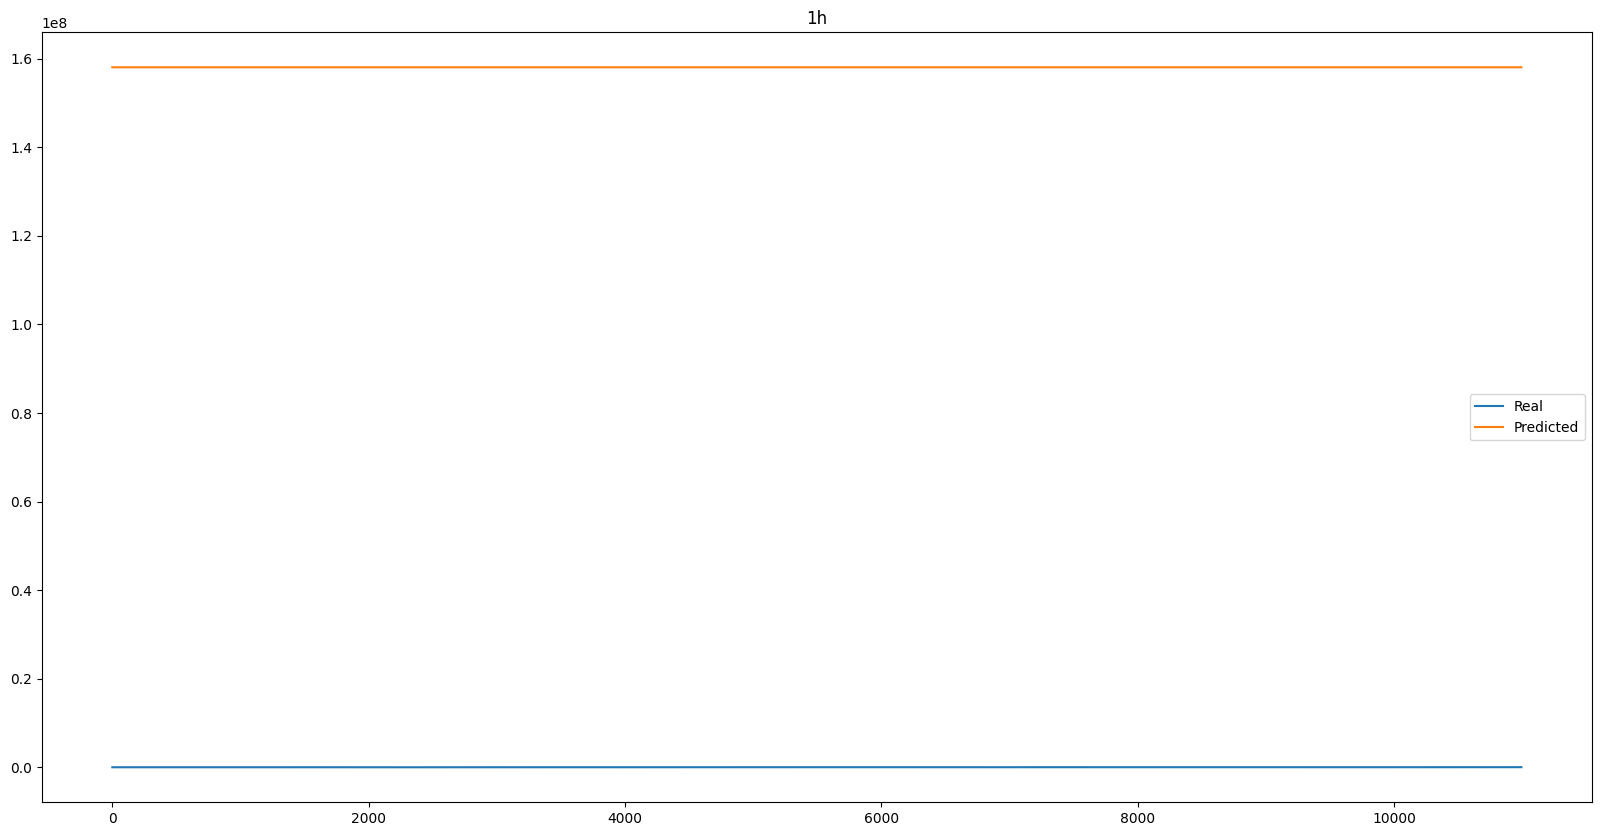

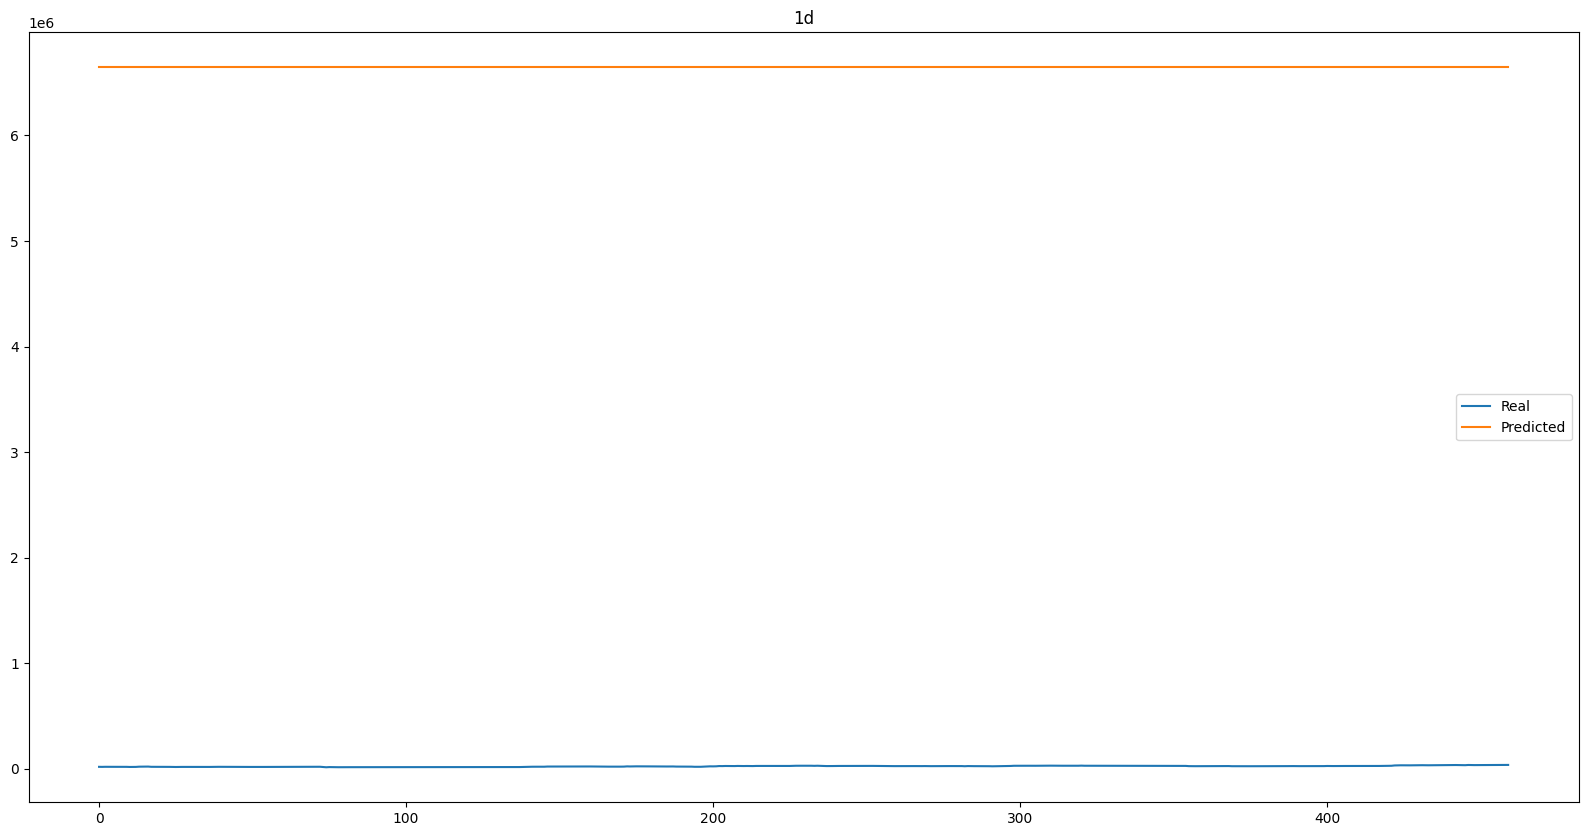

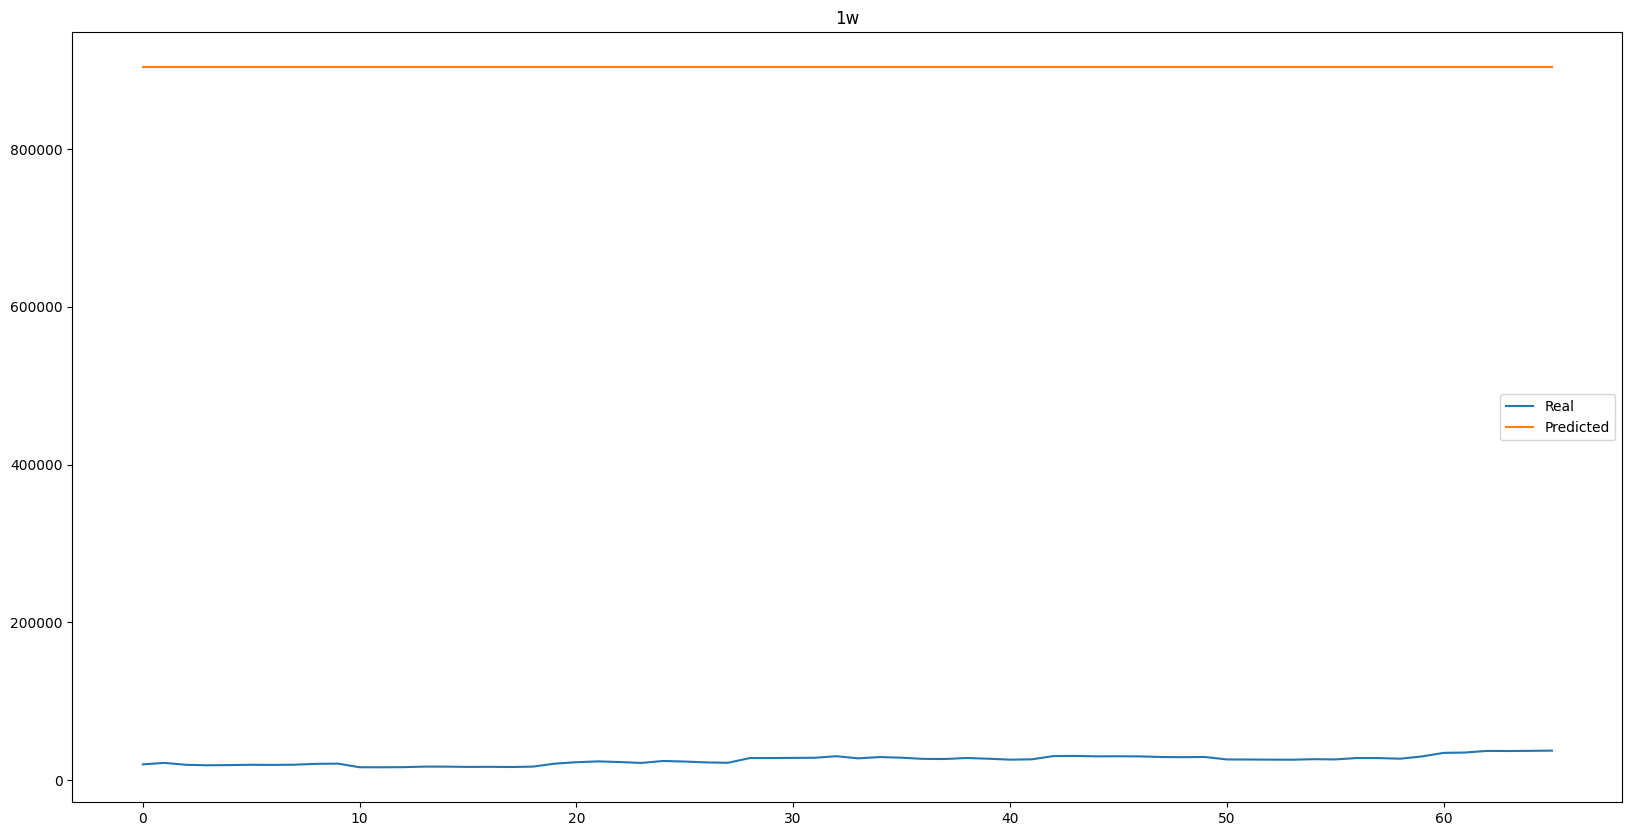

In [59]:
# Plot predictions and real values for Fourier analysis
for key, value in predictions.items():
    plt.figure(figsize=(20, 10))
    plt.plot(test_fourier[key].values, label="Real")
    plt.plot(value, label="Predicted")
    plt.title(key)
    plt.legend()
    plt.show()

Too bad for all timeframes, very big difference between real and predicted values